# **Assessment 2**

For our second assessment, we will be looking at sequential weather data. The data contains a number of relevant weather variables, recorded daily for a European city during a period of four decades.

However, this dataset has been corrupted, and some of the daily measurements are now missing. The goal of this assessment is to develop a neural network architecture that can recover the missing measurements!

<br>

---

<br>

The dataset has been saved as `.csv` files and has been separated into a `training_set/` folder and a `test_set.csv` file. The `training_set/` contains data for three of the four decades, separated in one individual file per decade:

- `training_set_0.csv` contains corrupted data for the first decade; `training_set_0_nogaps.csv` contains the same data before it was corrupted.
- `training_set_1.csv` contains corrupted data for the second decade; `training_set_1_nogaps.csv` contains the same data before it was corrupted.
- `training_set_2.csv` contains corrupted data for the third decade; `training_set_2_nogaps.csv` contains the same data before it was corrupted.

The `test_set.csv` file contains the remaining decade; this data is corrupted and contains gaps, but we have lost access to the data before corruption.

The architecture that you design in this assessment should use the data contained inside the `training_set` in order to recover the missing information in the data in `test_set.csv`. Note that decades `0`, `1`, and `2` are not necessarily consecutive.

Inside each of the `.csv` files, you will find the following columns:

- `date`
- `cloud_cover`
- `sunshine`
- `global_radiation`
- `max_temp`
- `mean_temp`
- `min_temp`
- `precipitation`
- `pressure`

<br>

All answers to the assessment should be contained within the structure below, but you are free to add new code and text cells as required to your answers. Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

Please, **make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

<br>

---

<br>

<br><br>

## **Question 1**  (25%)

Load the training and test datasets. Then, use the space below to present the following set of figures:

1. Using line plots, show the different variables in each dataset, both before and after corruption. Choose a single decade to plot, and plot the first 365 days of data. Plot the time series for each variable in an independent axis window. Make sure the axis windows are sized appropriately so that trends and corruption in the variables can be easily observed.
2. Plot a histogram for each variable in each dataset, across all decades, both before and after corruption.

<br>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install livelossplot

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset
import torch
from torch.utils.data import random_split
from torch import nn
from livelossplot import PlotLosses
from sklearn.preprocessing import StandardScaler, RobustScaler
import seaborn as sns

In [10]:
training_set = []
training_set_nogaps = []

for i in range(3):
  path_set = '/content/drive/MyDrive/Cw_deeplearning_2/training_set/training_set_' + str(i) + '.csv'
  training_set_df = pd.read_csv(path_set)
  training_set.append(training_set_df)

  path_set_nogaps = '/content/drive/MyDrive/Cw_deeplearning_2/training_set/training_set_' + str(i) + '_nogaps.csv'
  training_set_nogaps_df = pd.read_csv(path_set_nogaps)
  training_set_nogaps.append(training_set_nogaps_df)

training_set[0].head(5)


date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0     0          4.0       0.2              10.6       2.1       -1.3   
1     1          2.0       6.7              58.8      11.4       -2.1   
2     2          7.9      -0.0               5.7       9.6        NaN   
3     3          4.9       4.1              41.1       8.0        NaN   
4     4          3.9       1.3              19.5       8.4        NaN   

   min_temp  precipitation  pressure  
0      -4.2            0.0  101282.7  
1      -6.0            0.2  102455.7  
2      -5.8            9.9  101920.4  
3       0.8            0.0  100441.5  
4       1.7            0.0  100625.2

In [11]:
training_set_nogaps[0].head(5)

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0     0          4.0       0.2              10.6       2.1       -1.3   
1     1          2.0       6.7              58.8      11.4       -2.1   
2     2          7.9      -0.0               5.7       9.6        3.0   
3     3          4.9       4.1              41.1       8.0        4.7   
4     4          3.9       1.3              19.5       8.4        4.8   

   min_temp  precipitation  pressure  
0      -4.2            0.0  101282.7  
1      -6.0            0.2  102455.7  
2      -5.8            9.9  101920.4  
3       0.8            0.0  100441.5  
4       1.7            0.0  100625.2

In [12]:
test_set_df = pd.read_csv('/content/drive/MyDrive/Cw_deeplearning_2/test_set.csv')
test_set_df.head(5)

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0     0          7.1       0.5              15.5      11.1        7.4   
1     1          7.1       0.8              19.4      11.0        7.7   
2     2          8.0       0.0               8.8       9.3        9.2   
3     3          4.9       2.6              30.8      11.6        6.9   
4     4          NaN       2.0              25.0      10.5        6.1   

   min_temp  precipitation  pressure  
0       4.6            0.0  102472.1  
1       5.2            0.0  102547.2  
2       7.6            6.1  101847.4  
3       4.3            0.0  101370.4  
4       1.9            0.7  101383.3

### Plotting the time series

In [13]:
decade_set = training_set[0].iloc[:365] # we choose the first decade to plot and select the first 365 days
decade_set_nogaps = training_set_nogaps[0].iloc[:365]

decade_set.columns

Index(['date', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp',
       'mean_temp', 'min_temp', 'precipitation', 'pressure'],
      dtype='object')

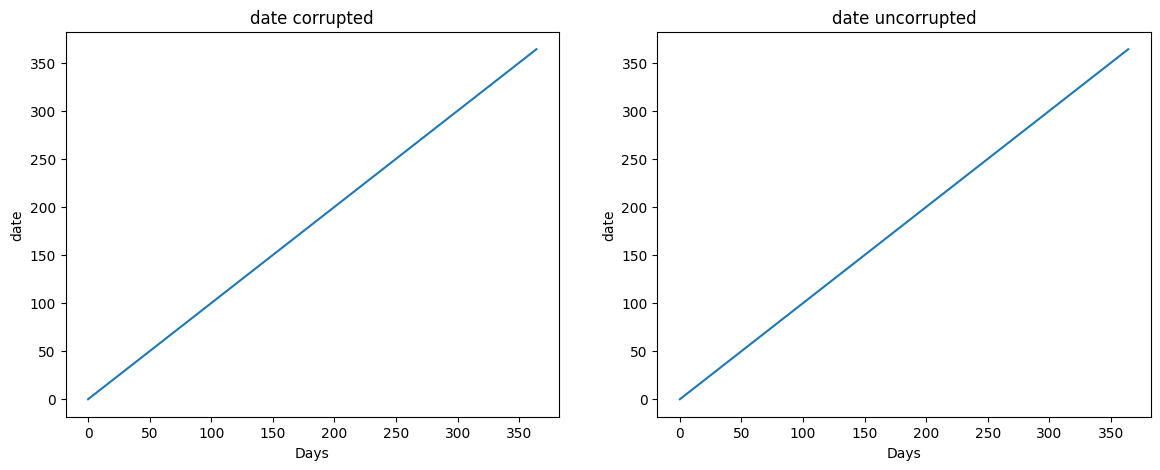

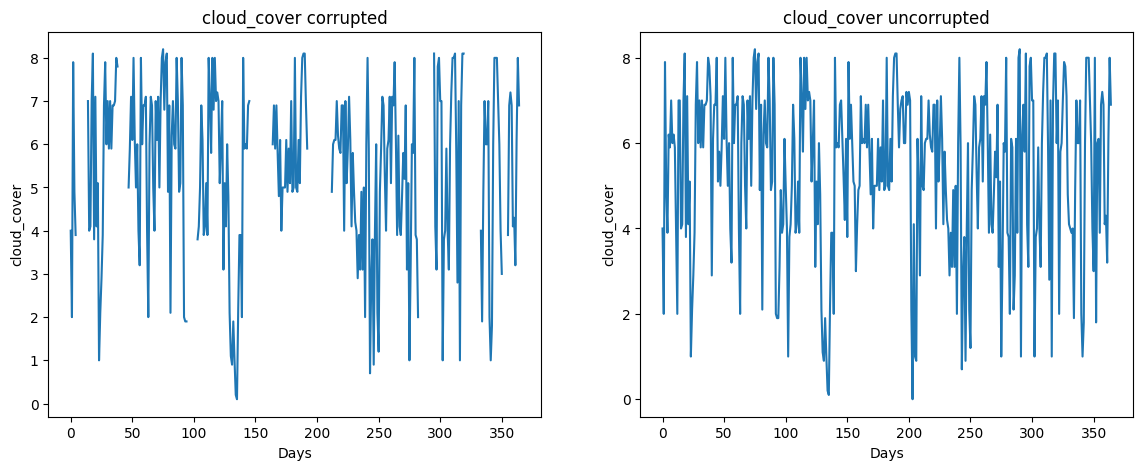

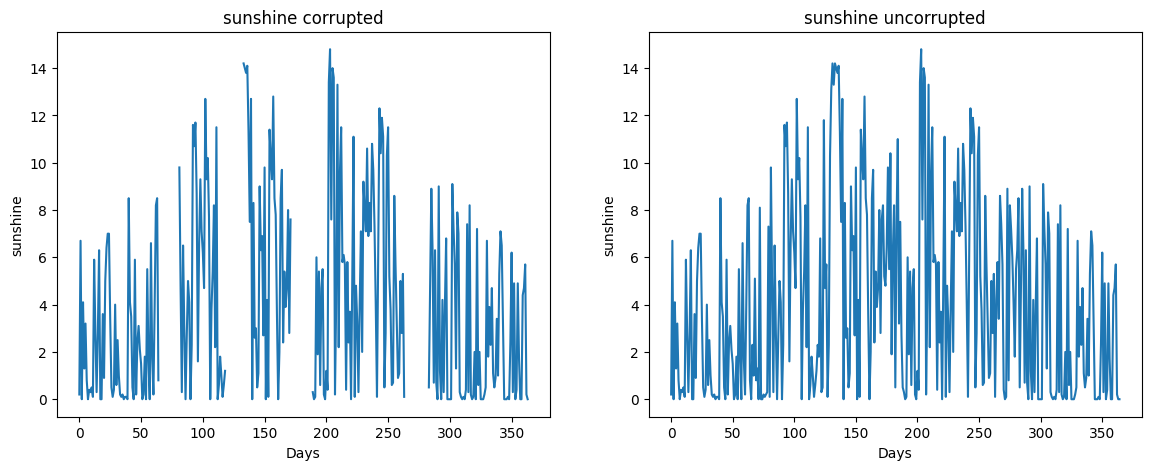

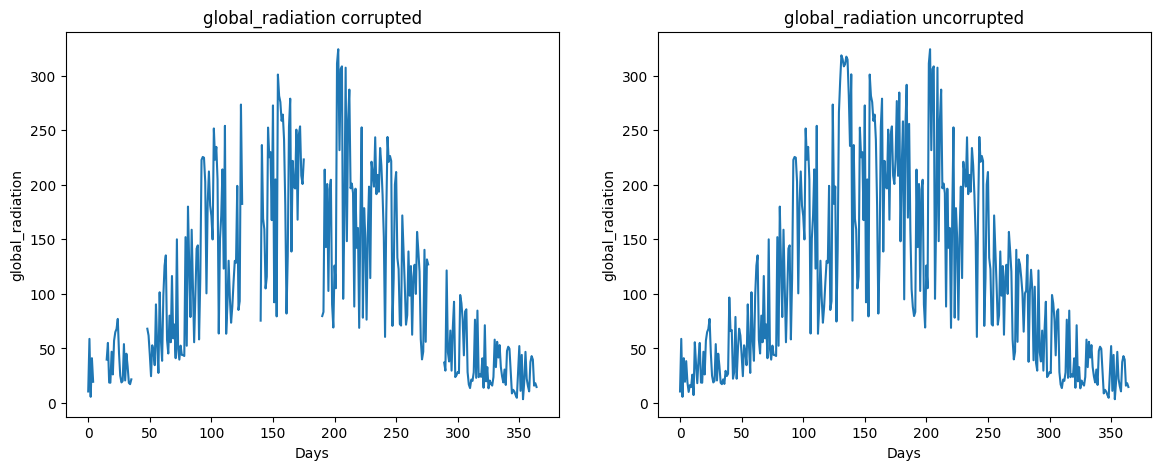

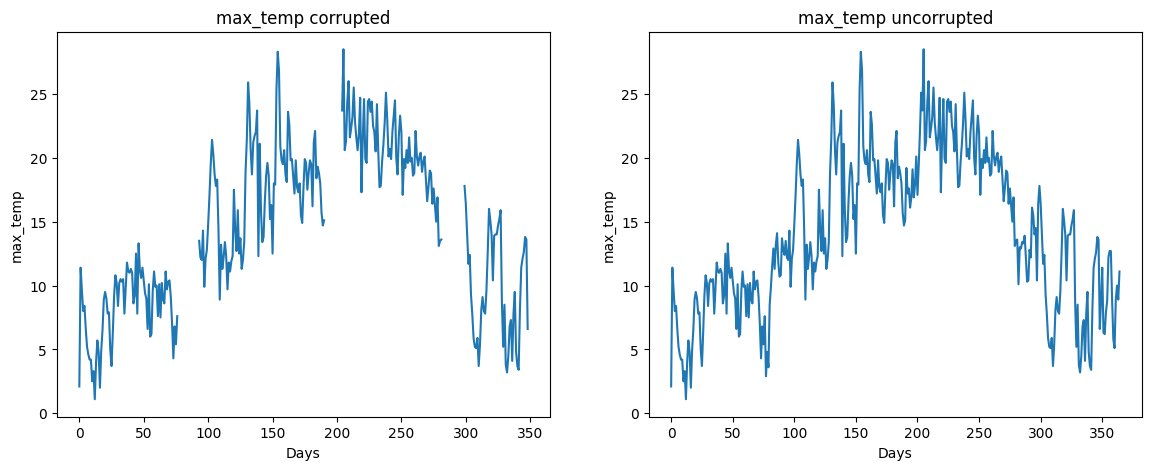

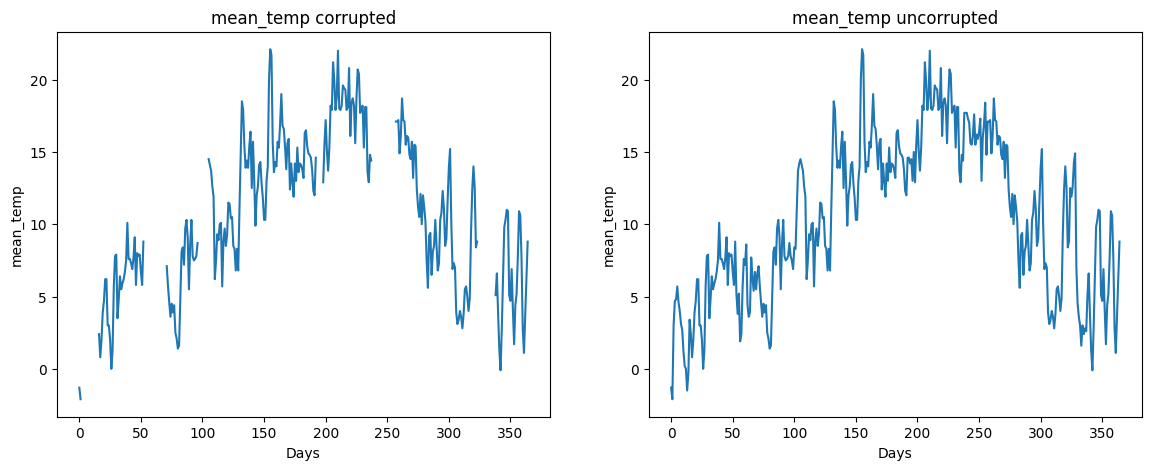

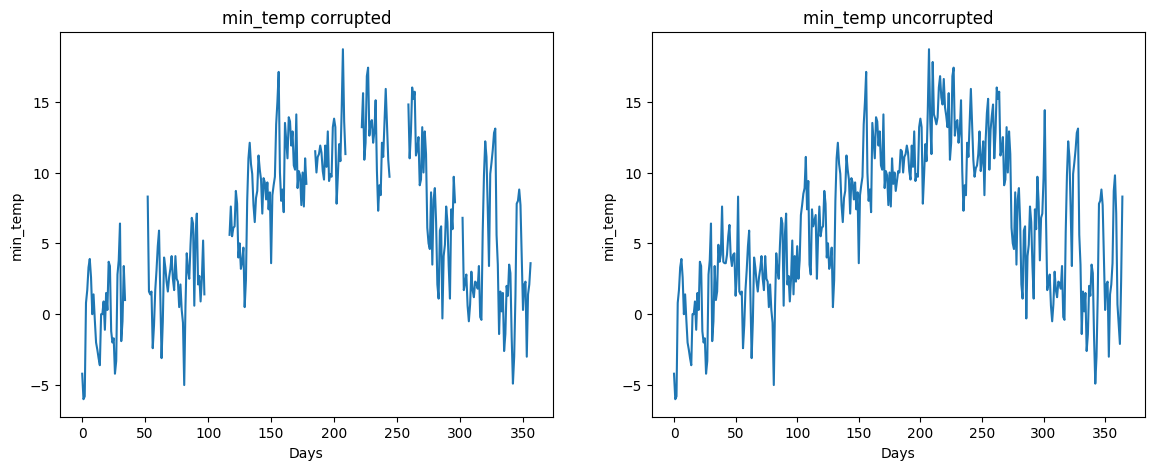

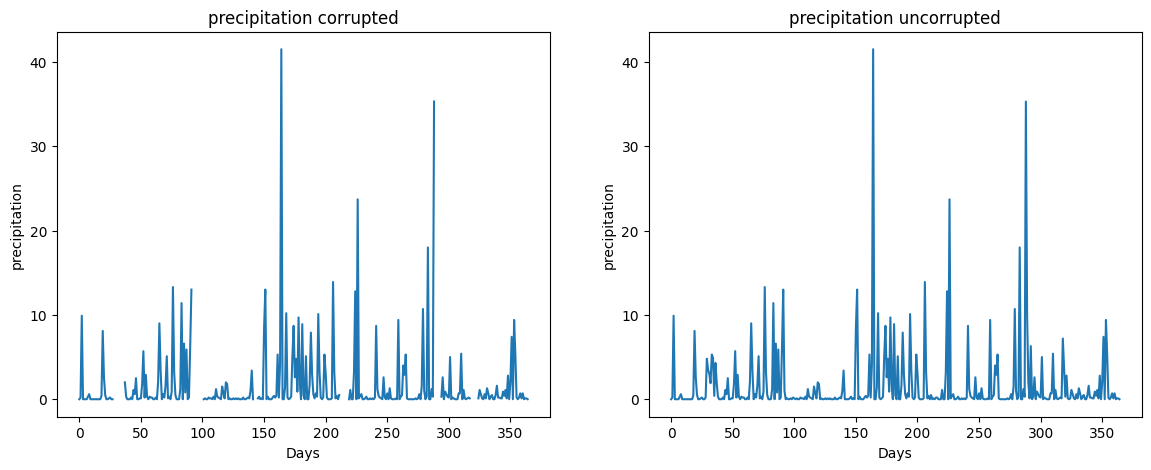

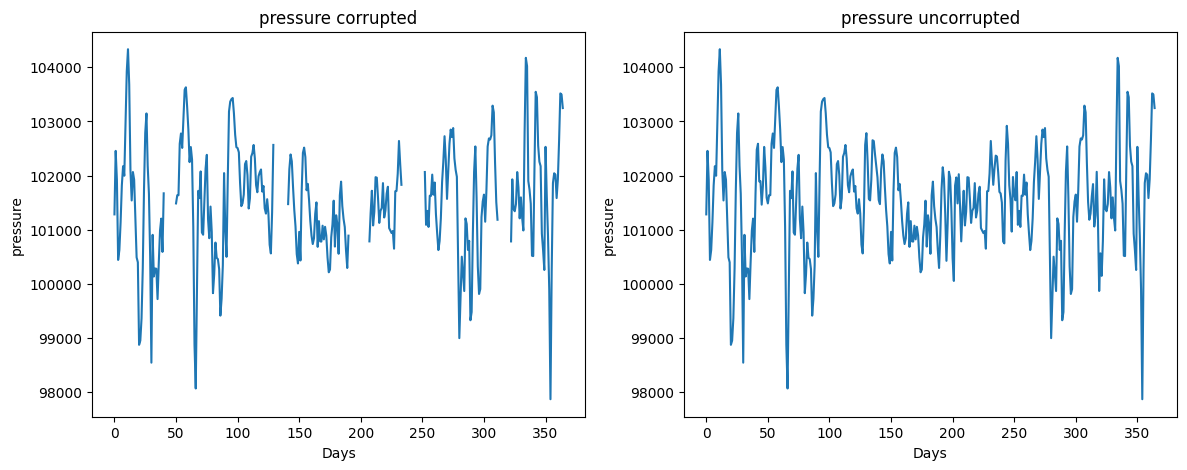

In [14]:
date = list(decade_set.date)
for column in list(decade_set.columns):
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  variable = decade_set[column].to_numpy()
  plt.plot(date, variable)
  plt.title(f'{column} corrupted')
  plt.xlabel('Days')
  plt.ylabel(f'{column}')

  plt.subplot(1, 2, 2)
  variable2 = decade_set_nogaps[column].to_numpy()
  plt.plot(date, variable2)
  plt.title(f'{column} uncorrupted')
  plt.xlabel('Days')
  plt.ylabel(f'{column}')

plt.show()

### Plotting the test set

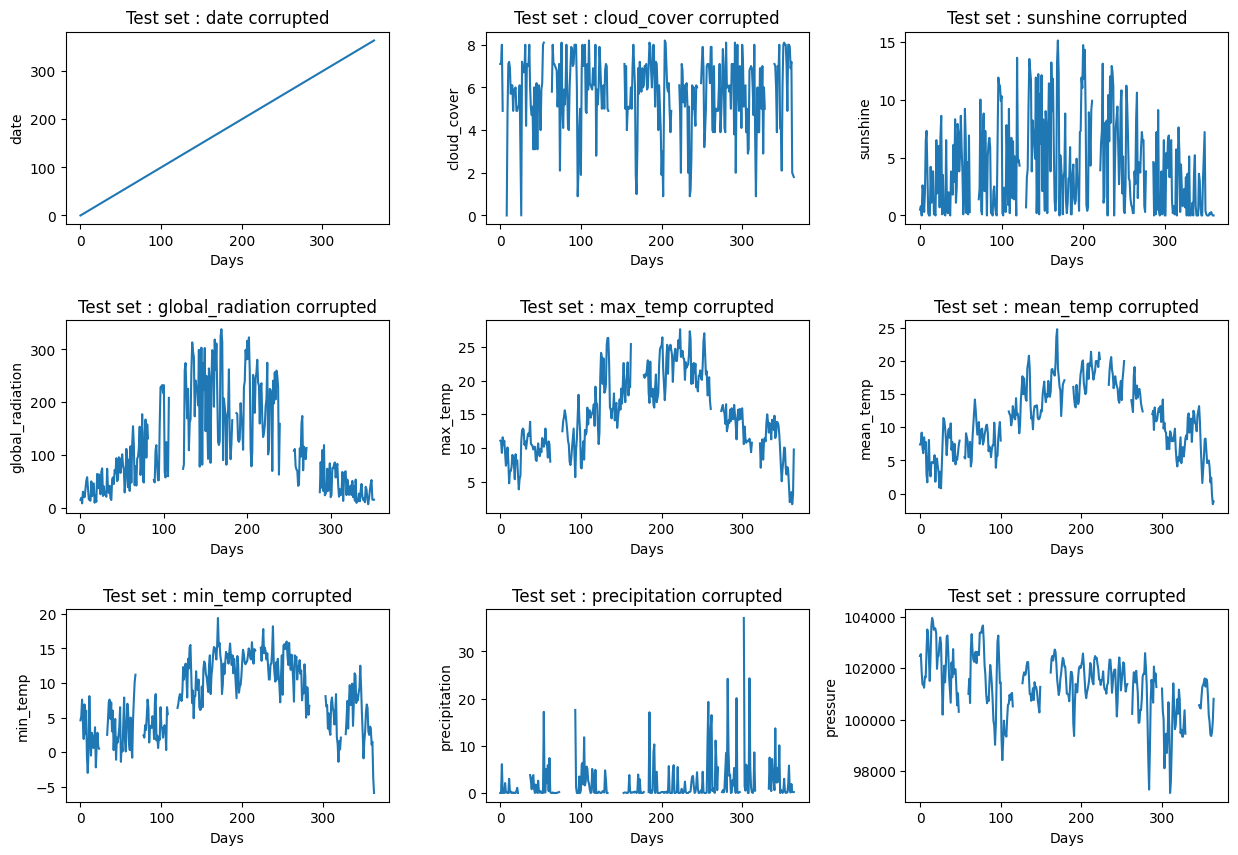

In [15]:
date = list(decade_set.date)
plt.figure(figsize=(15, 10))

for i, column in enumerate(list(decade_set.columns)):
  plt.subplot(3, 3, i+1)
  variable = test_set_df[column].iloc[:365].to_numpy()
  plt.plot(date, variable)
  plt.title(f'Test set : {column} corrupted')
  plt.xlabel('Days')
  plt.ylabel(f'{column}')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

### Plotting the histograms

<ipython-input-16-1369eb74ed4c>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 5))


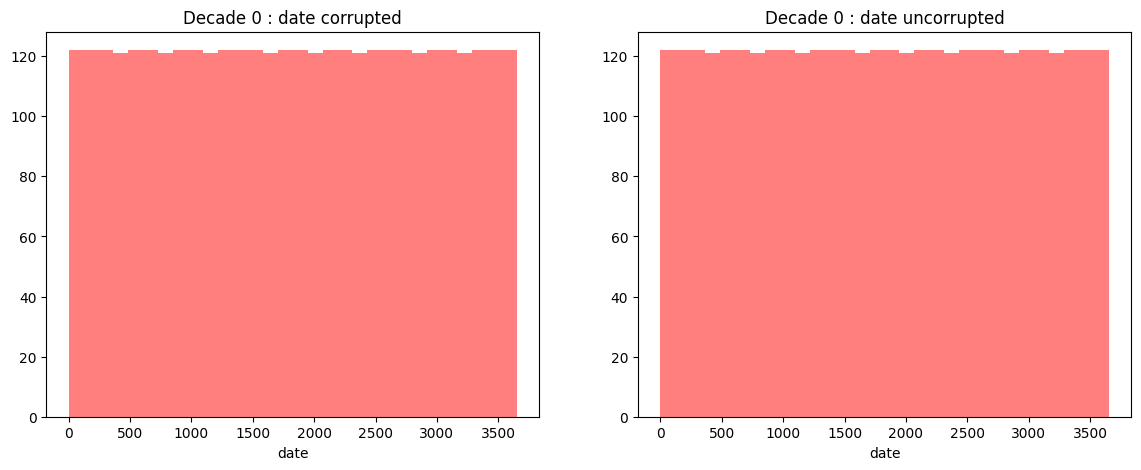

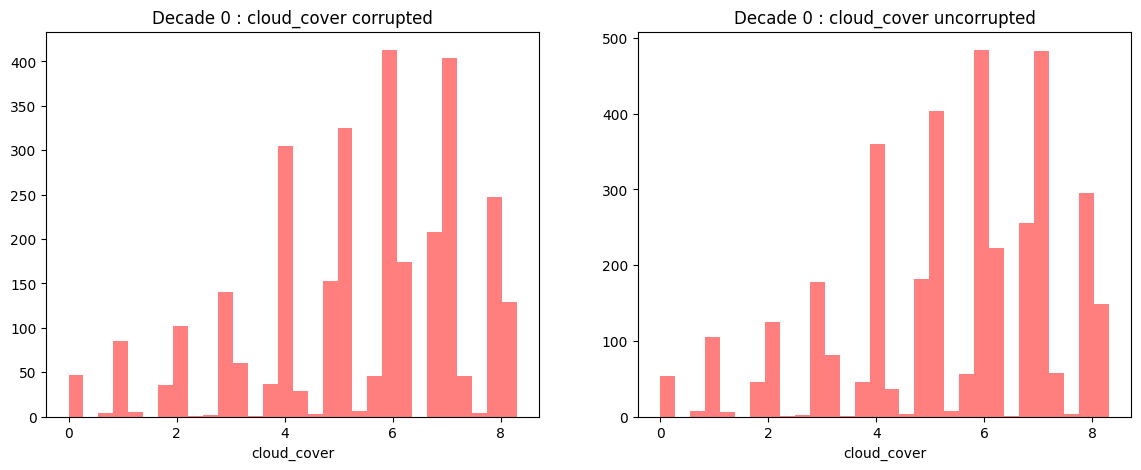

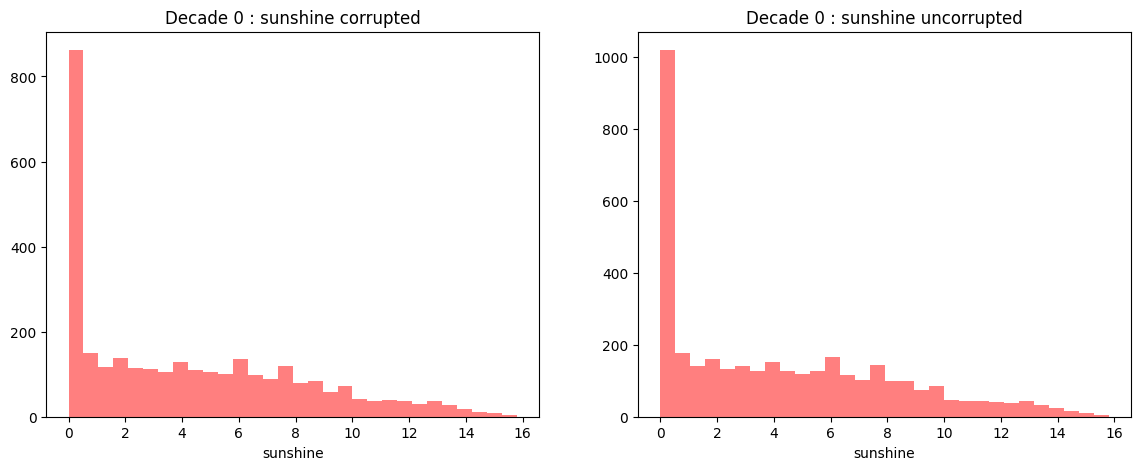

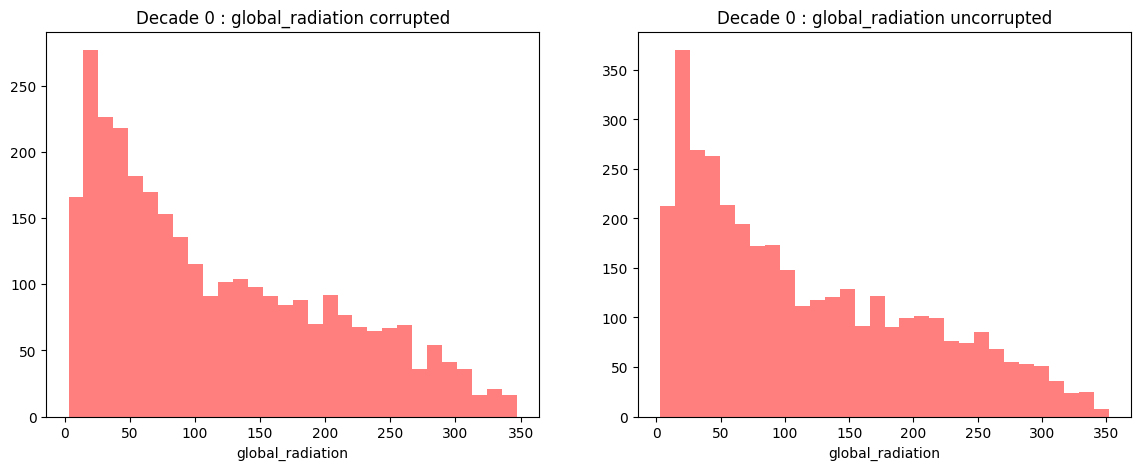

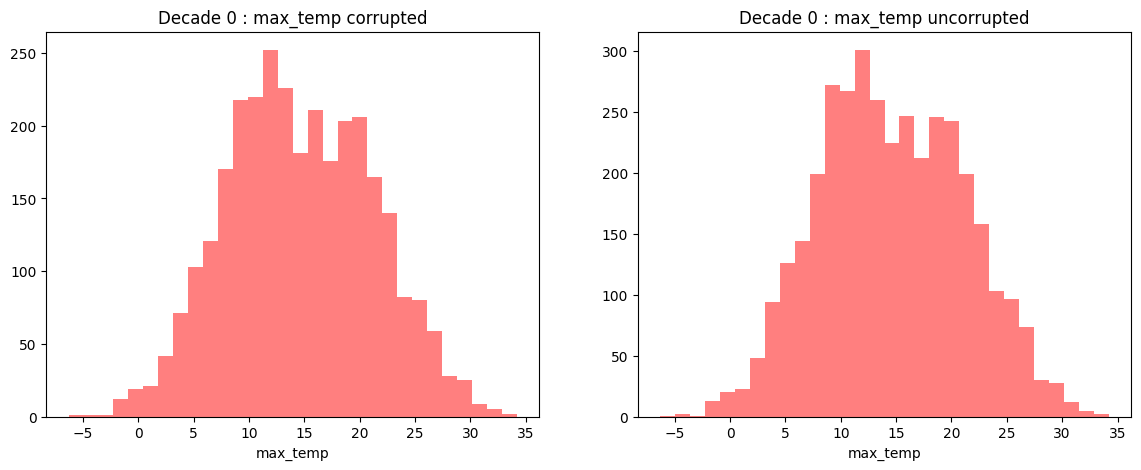

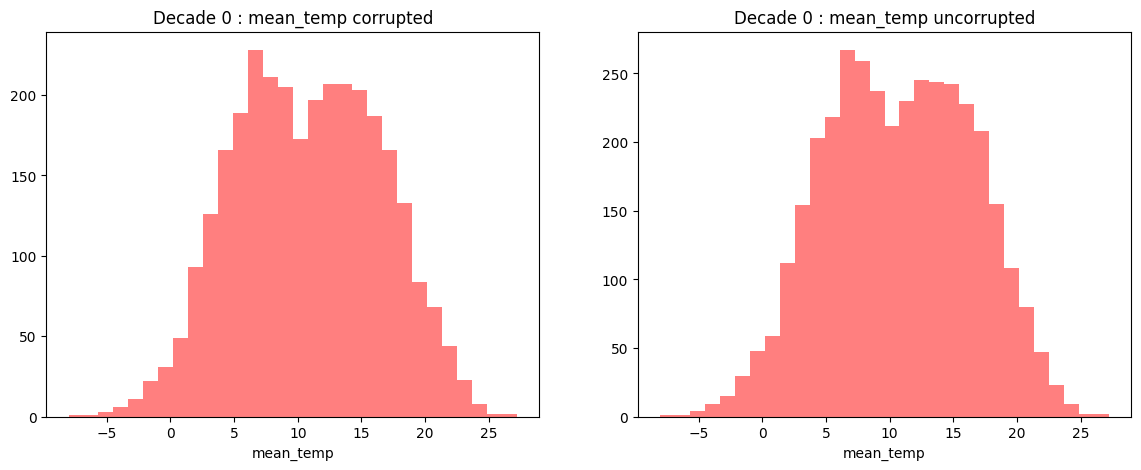

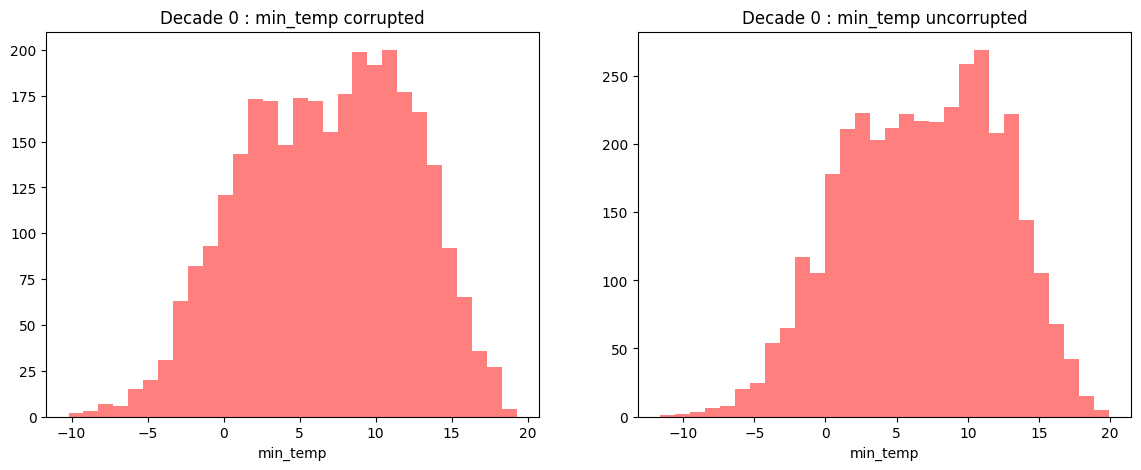

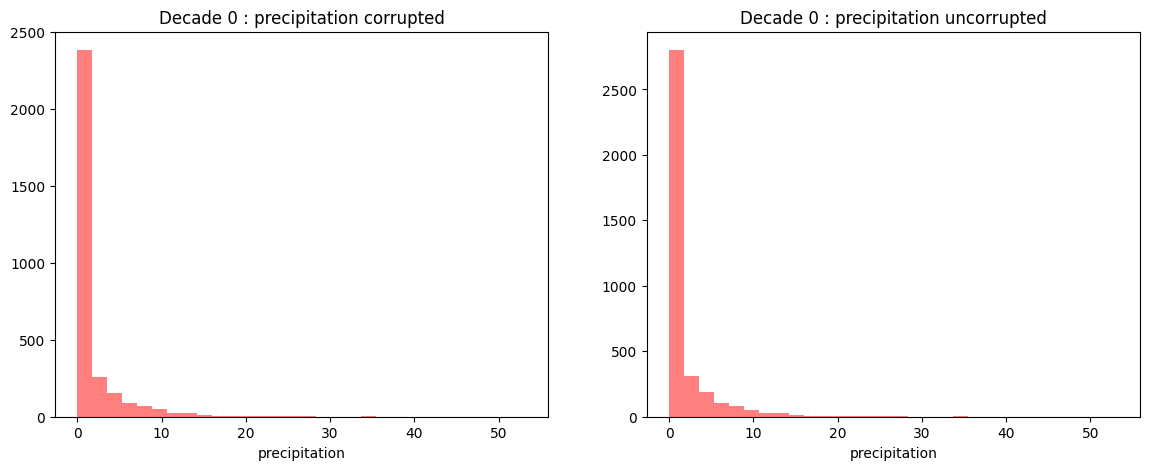

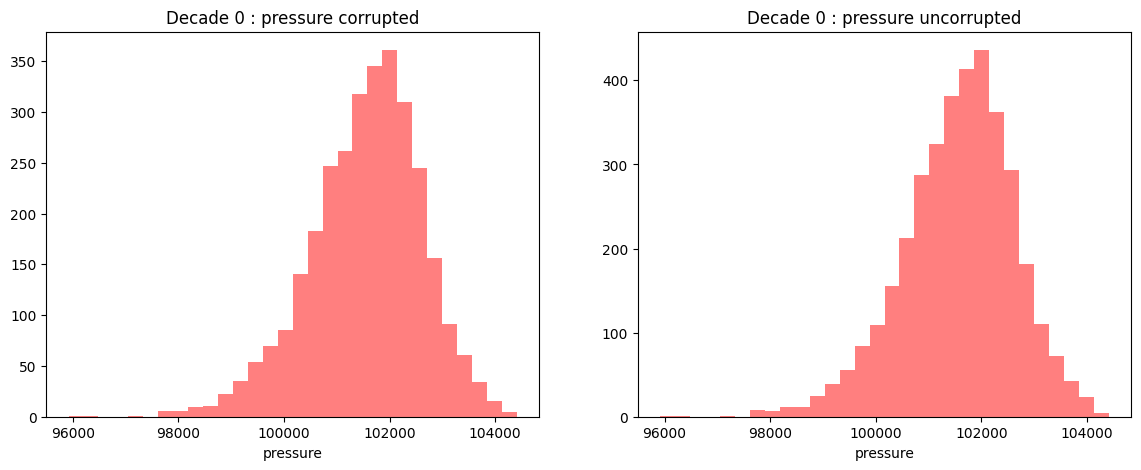

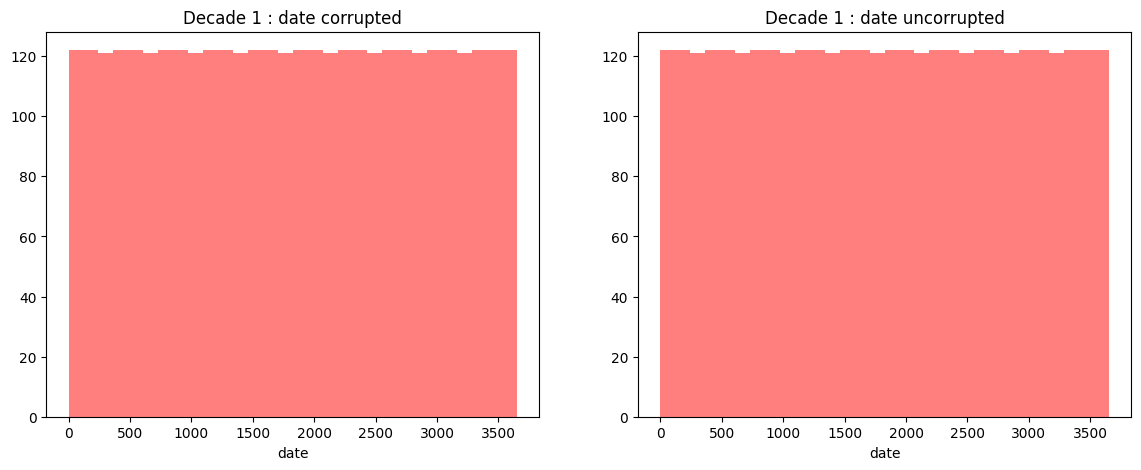

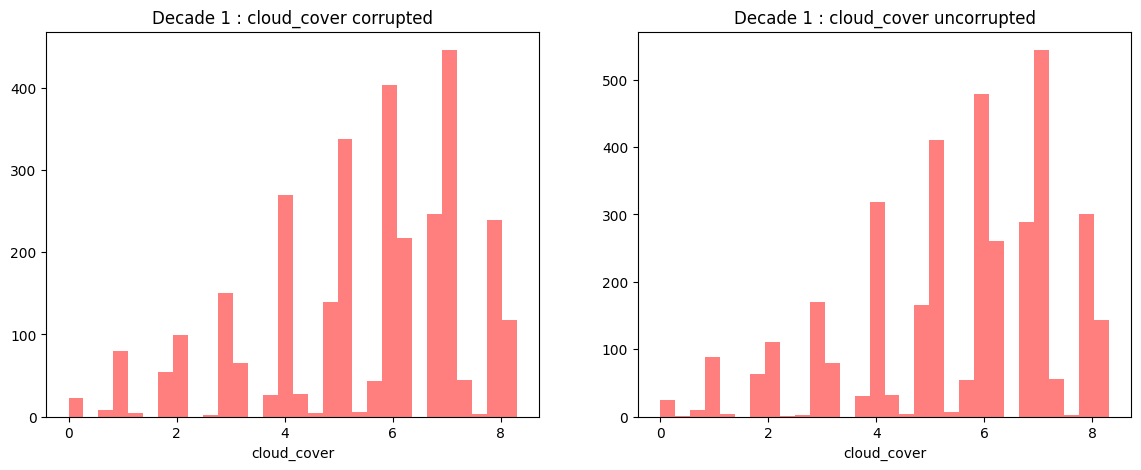

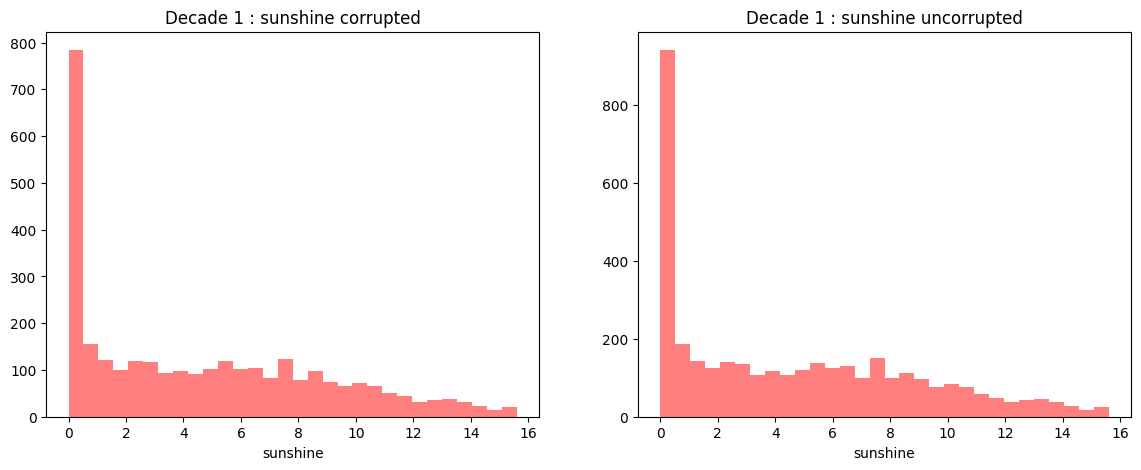

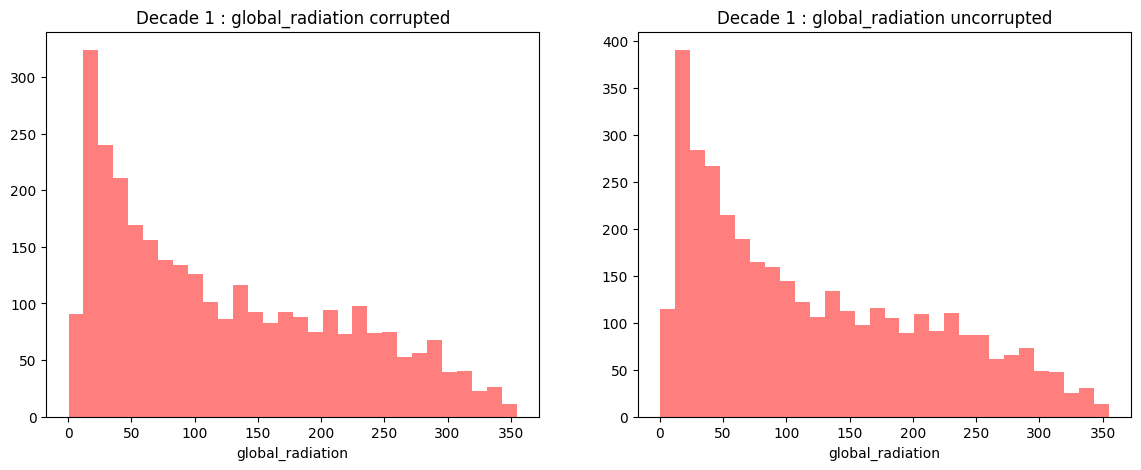

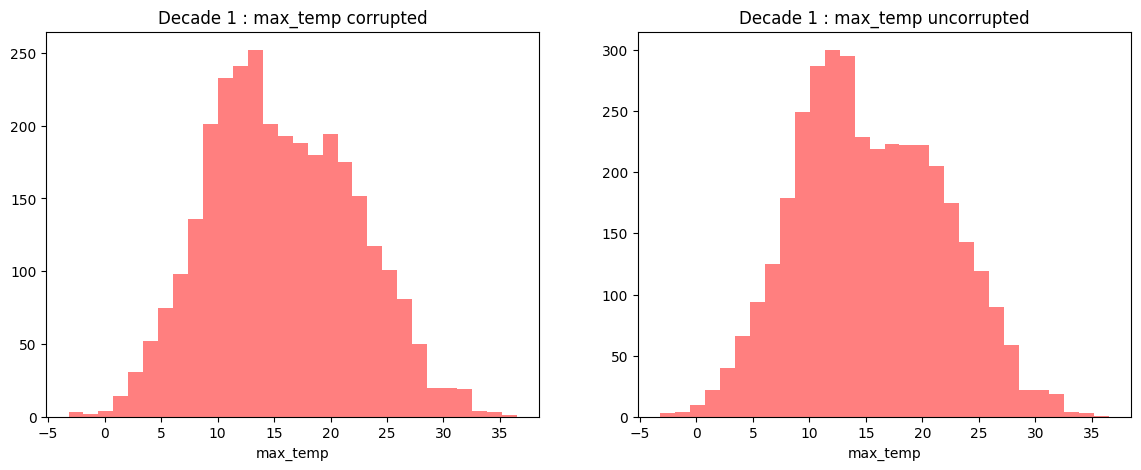

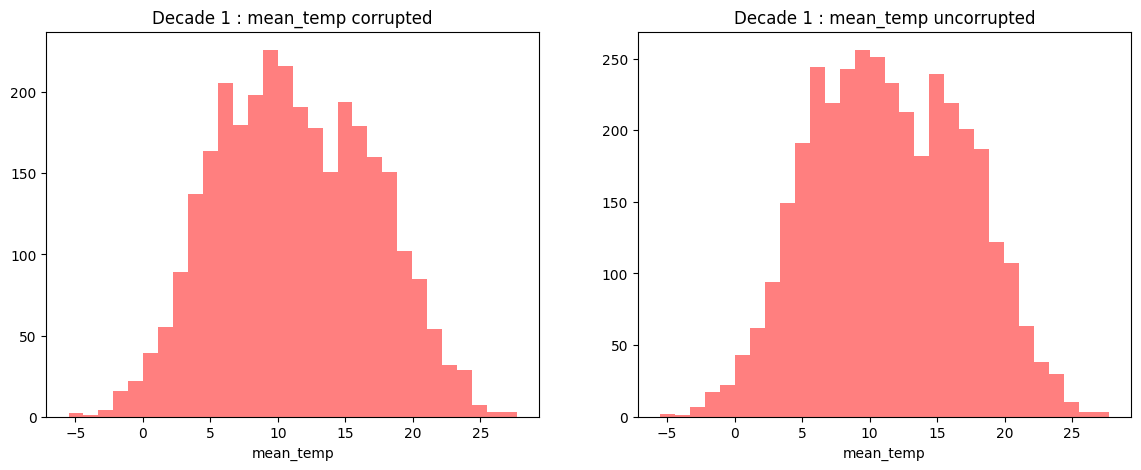

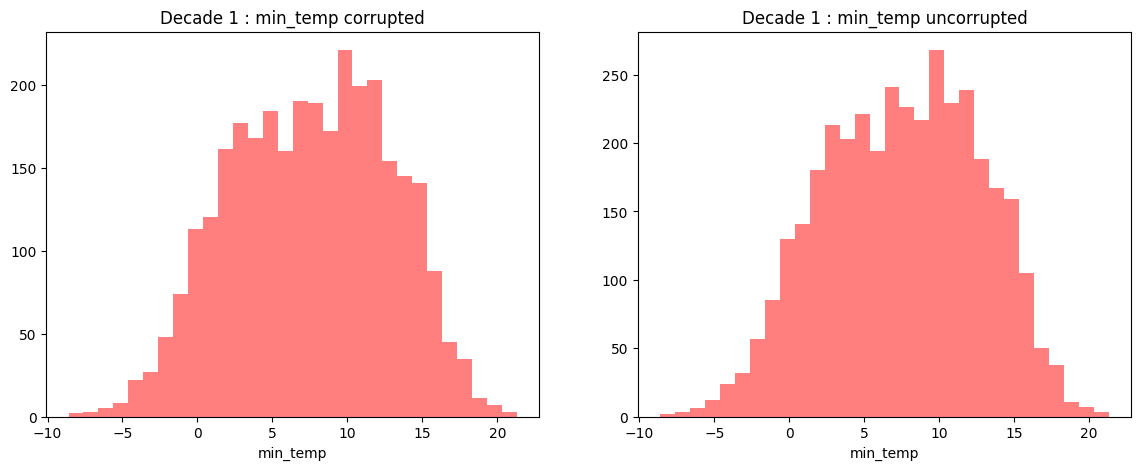

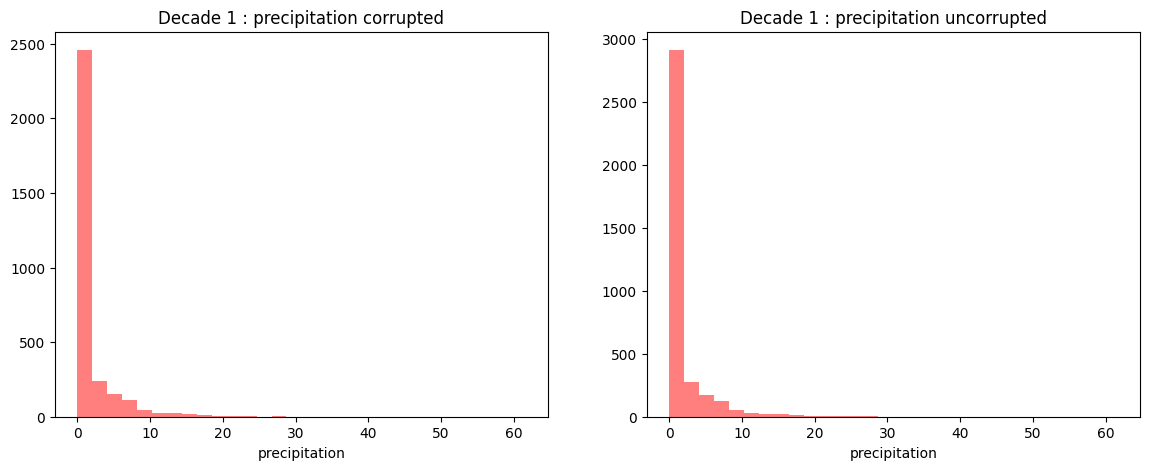

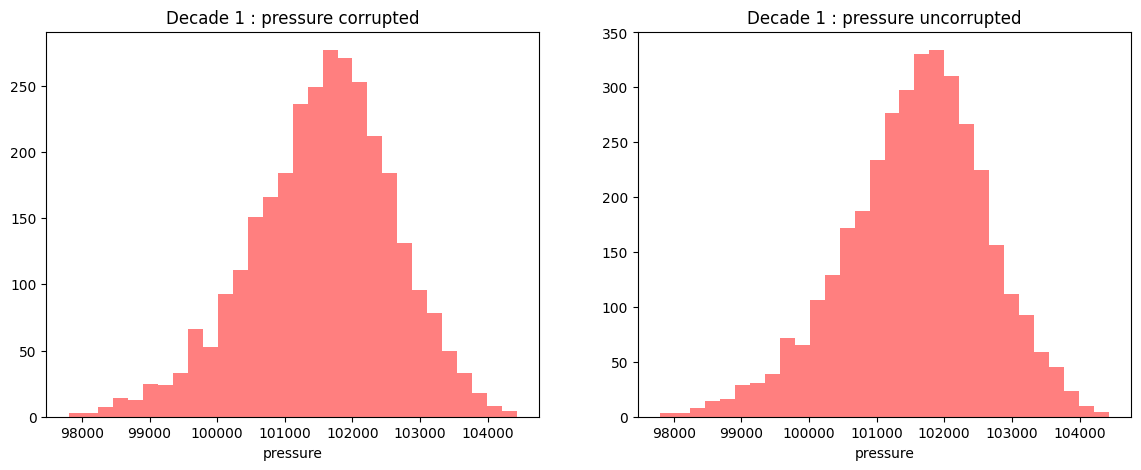

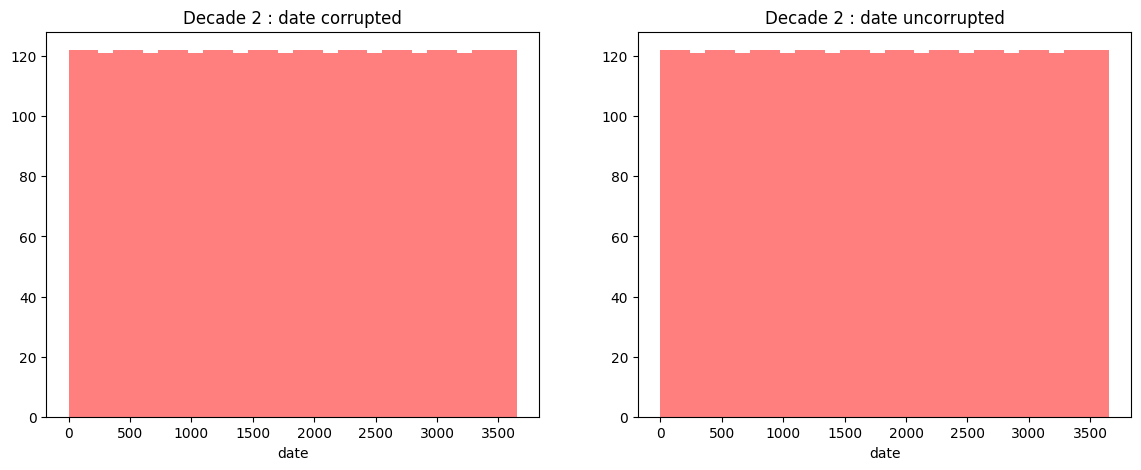

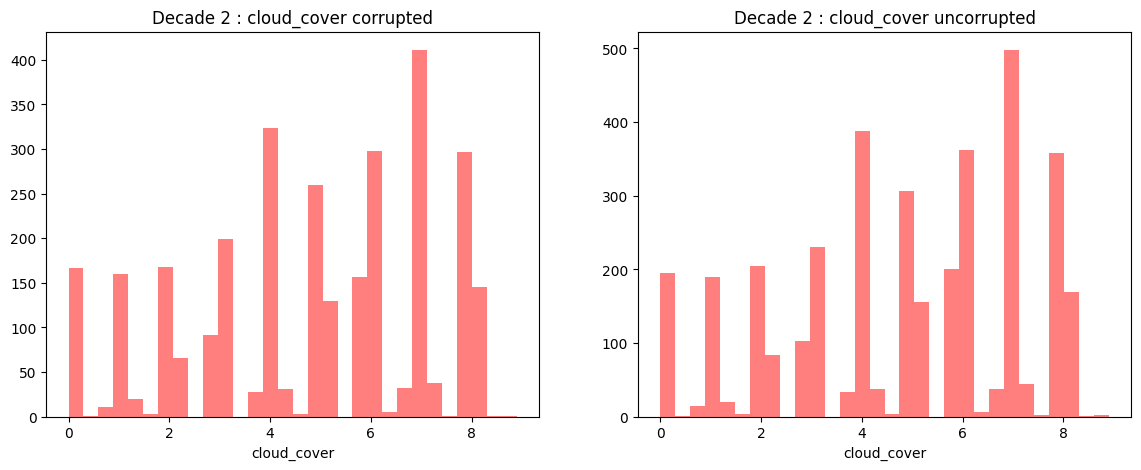

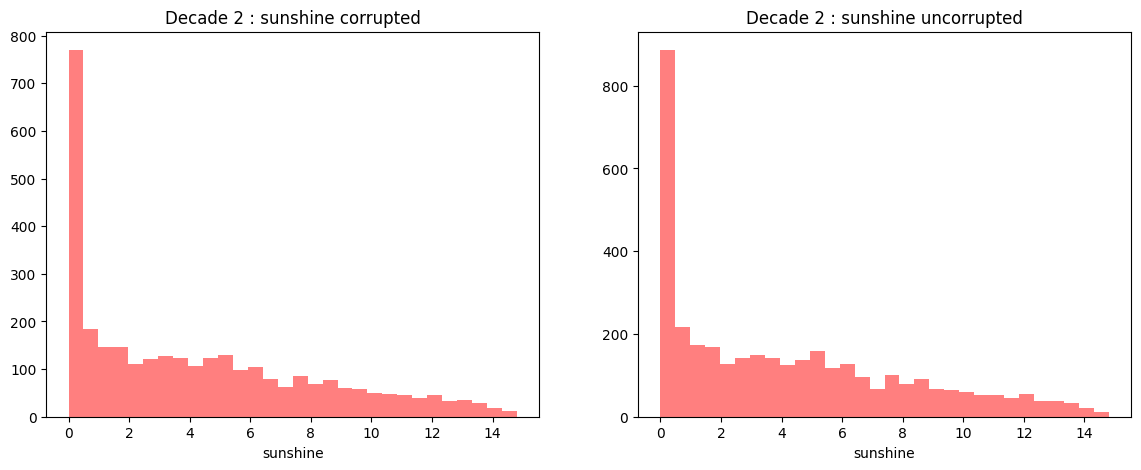

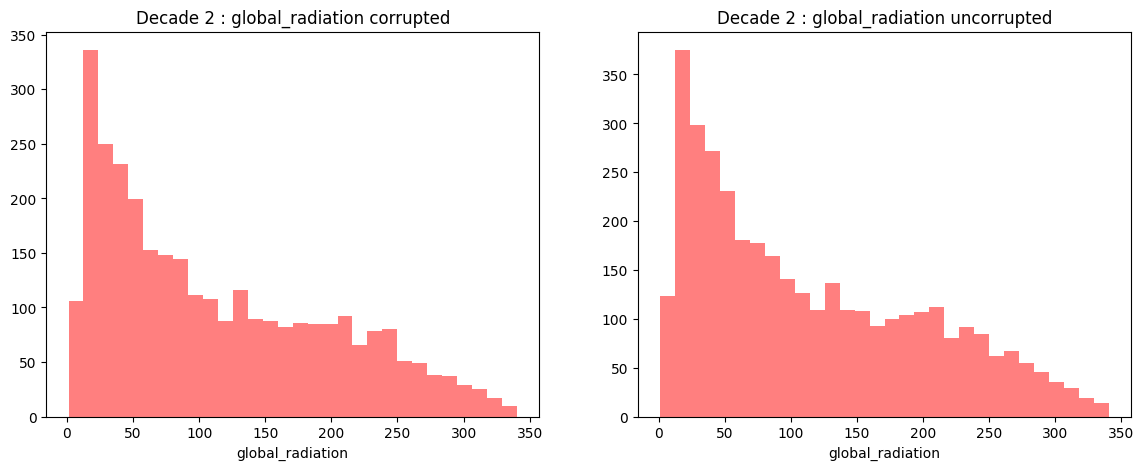

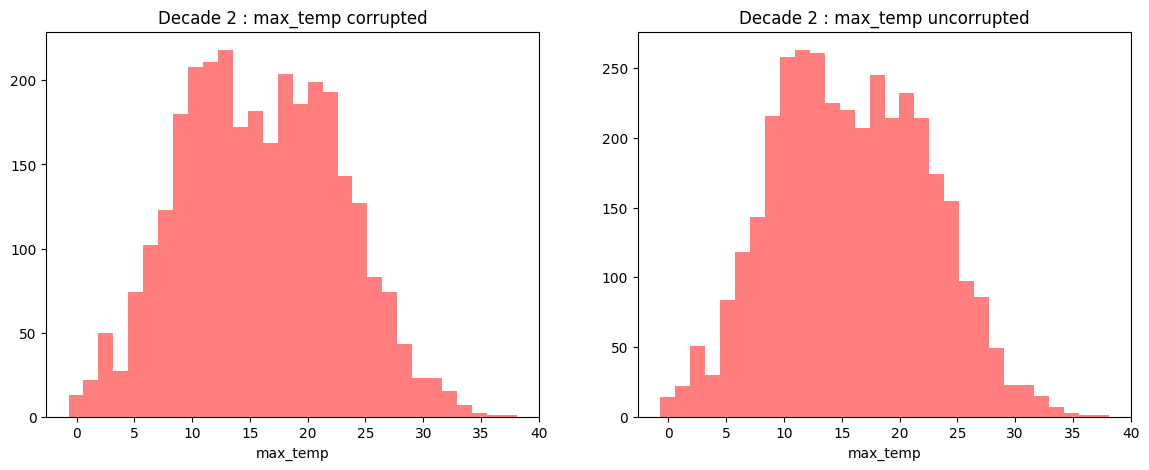

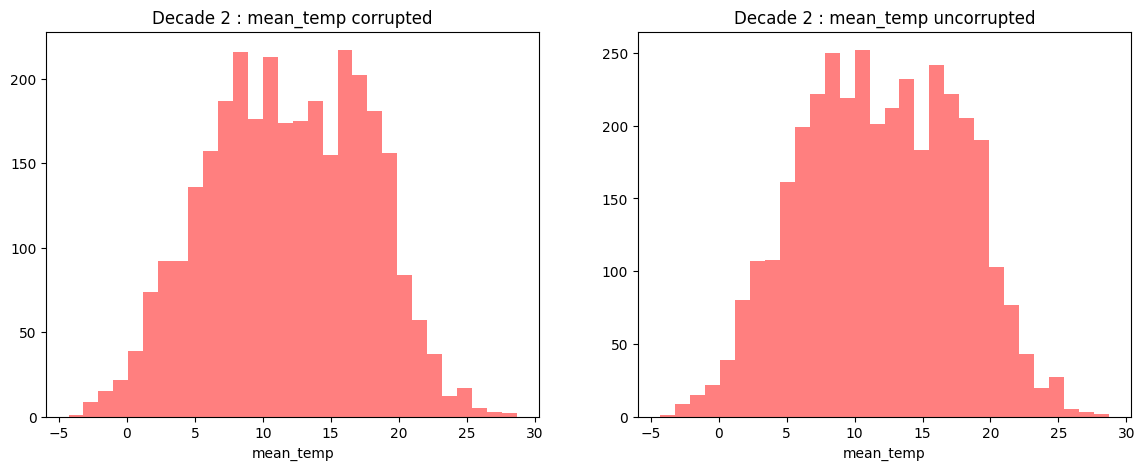

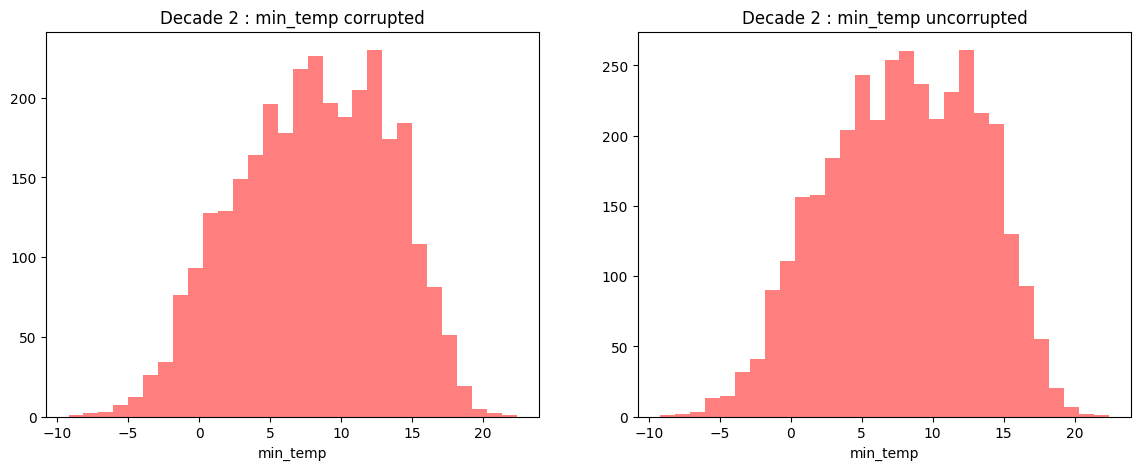

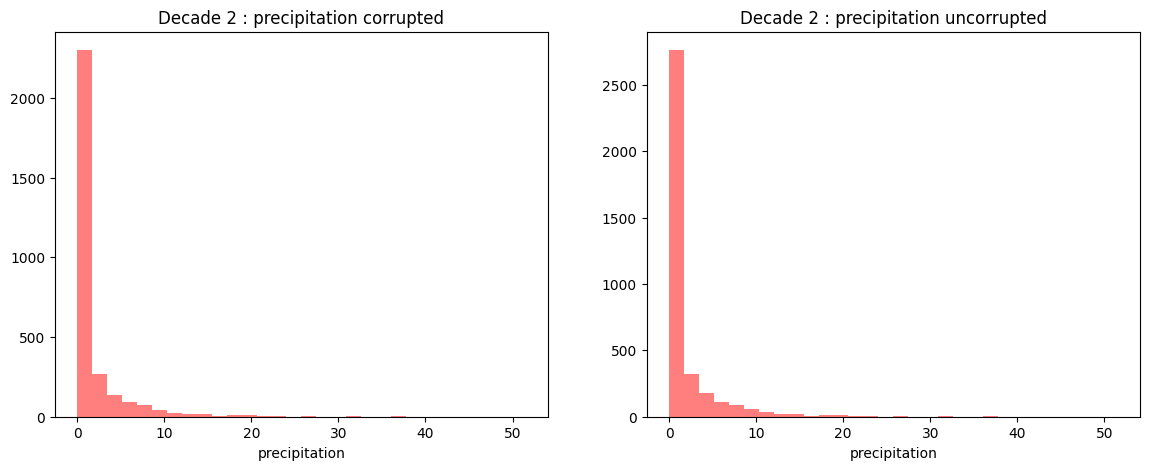

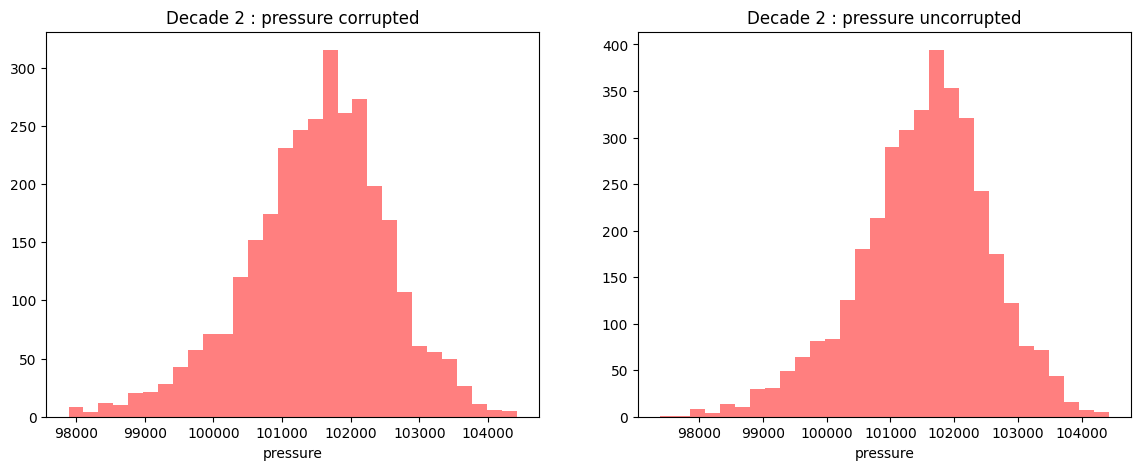

In [16]:
columns = list(training_set[0].columns)

for i in range(3):
  for column in list(columns):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    variable = training_set[i][column].to_numpy()
    plt.hist(variable, bins=30, alpha=0.5, label='Corrupted', color='red')
    plt.title(f'Decade {i} : {column} corrupted')
    plt.xlabel(f'{column}')

    plt.subplot(1, 2, 2)
    variable2 = training_set_nogaps[i][column].to_numpy()
    plt.hist(variable2, bins=30, alpha=0.5, label='Corrupted', color='red')
    plt.title(f'Decade {i} : {column} uncorrupted')
    plt.xlabel(f'{column}')

plt.show()

### plotting the test dataset

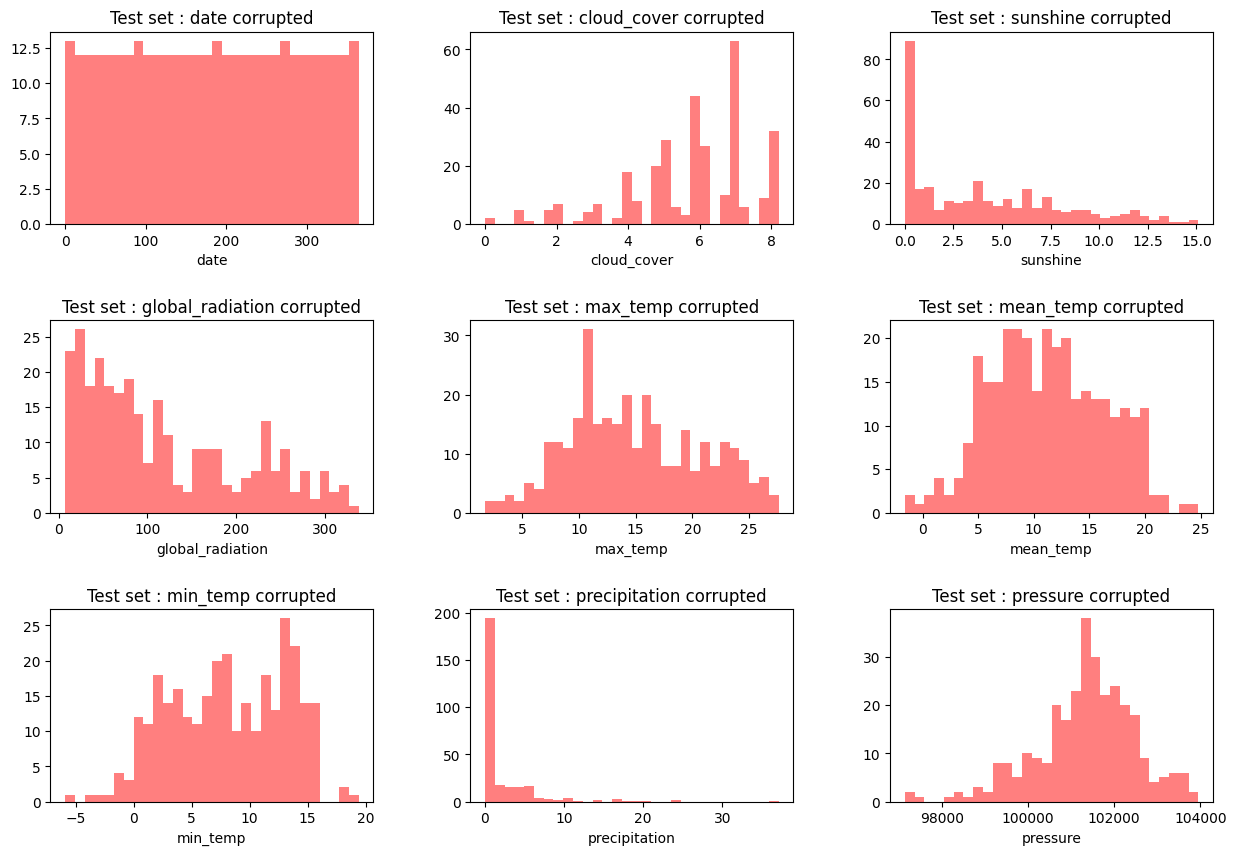

In [17]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns):
  plt.subplot(3, 3, i+1)
  variable = test_set_df[column].iloc[:365].to_numpy()
  plt.hist(variable, bins=30, alpha=0.5, label='Corrupted', color='red')
  plt.title(f'Test set : {column} corrupted')
  plt.xlabel(f'{column}')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

<br>

---

<br>

## **Question 2**  (25%)

Using the data loaded in **Question 1**, create a PyTorch `TensorDataset`, and create one `DataLoader` for the training set and another one for the test set.

The training loader should provide batches of weather data that have been corrupted, as well as the corresponding, paired un-corrupted batch of data. The test loader should provide batches of corrupted weather data, with no corresponding uncorrupted labels.

Using line plots, show here one batch from both the training and test datasets before and after corruption. Use different axis windows for input and label of the batch.

<br>



#### I concatenate all the decades into one dataframe

In [18]:
training_set_concat = pd.concat([training_set[0], training_set[1], training_set[2]], axis=0)
training_set_concat.head(5)

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0     0          4.0       0.2              10.6       2.1       -1.3   
1     1          2.0       6.7              58.8      11.4       -2.1   
2     2          7.9      -0.0               5.7       9.6        NaN   
3     3          4.9       4.1              41.1       8.0        NaN   
4     4          3.9       1.3              19.5       8.4        NaN   

   min_temp  precipitation  pressure  
0      -4.2            0.0  101282.7  
1      -6.0            0.2  102455.7  
2      -5.8            9.9  101920.4  
3       0.8            0.0  100441.5  
4       1.7            0.0  100625.2

In [19]:
len(training_set_concat)

10954

In [20]:
training_set_labels = pd.concat([training_set_nogaps[0], training_set_nogaps[1], training_set_nogaps[2]], axis=0)
training_set_labels

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0        0          4.0       0.2              10.6       2.1       -1.3   
1        1          2.0       6.7              58.8      11.4       -2.1   
2        2          7.9      -0.0               5.7       9.6        3.0   
3        3          4.9       4.1              41.1       8.0        4.7   
4        4          3.9       1.3              19.5       8.4        4.8   
...    ...          ...       ...               ...       ...        ...   
3646  3646          6.8      -0.0              12.4       8.1        5.9   
3647  3647          8.0       0.0               6.5      10.3        7.6   
3648  3648          7.9       0.0              13.7      10.0        8.0   
3649  3649          6.0       2.1              33.1      11.9        8.4   
3650  3650          0.0       3.4              39.5       9.3        6.5   

      min_temp  precipitation  pressure  
0         -4.2            0.0  101282.7  
1         -6.0            0.2  102455.7  
2         -5.8            9.9  101920.4  
3          0.8            0.0  100441.5  
4          1.7            0.0  100625.2  
...        ...            ...       ...  
3646       1.3            2.5  101671.8  
3647       6.5            0.0  102951.5  
3648       6.6            0.1  103596.6  
3649       7.7            0.3  103409.4  
3650       1.1            0.0  102927.7  

[10954 rows x 9 columns]

### Normalisation

In [21]:
training_set_norm = training_set_concat.copy()
training_set_nogaps_norm = training_set_labels.copy()
test_set_df_norm = test_set_df.copy()

In [22]:

scaler = RobustScaler()
training_set_norm = scaler.fit_transform(training_set_norm)
training_set_norm = pd.DataFrame(training_set_norm, columns=training_set_concat.columns, index=training_set_concat.index)

training_set_nogaps_norm = scaler.transform(training_set_nogaps_norm)
training_set_nogaps_norm = pd.DataFrame(training_set_nogaps_norm, columns=training_set_labels.columns, index=training_set_labels.index)


In [23]:
test_set_df_norm = scaler.transform(test_set_df_norm)
test_set_df_norm = pd.DataFrame(test_set_df_norm, columns=test_set_df.columns, index=test_set_df.index)

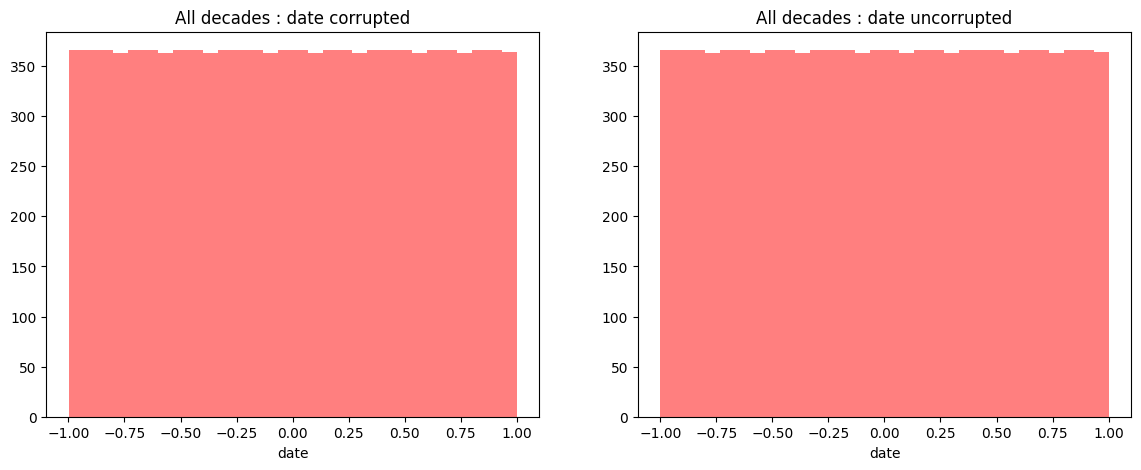

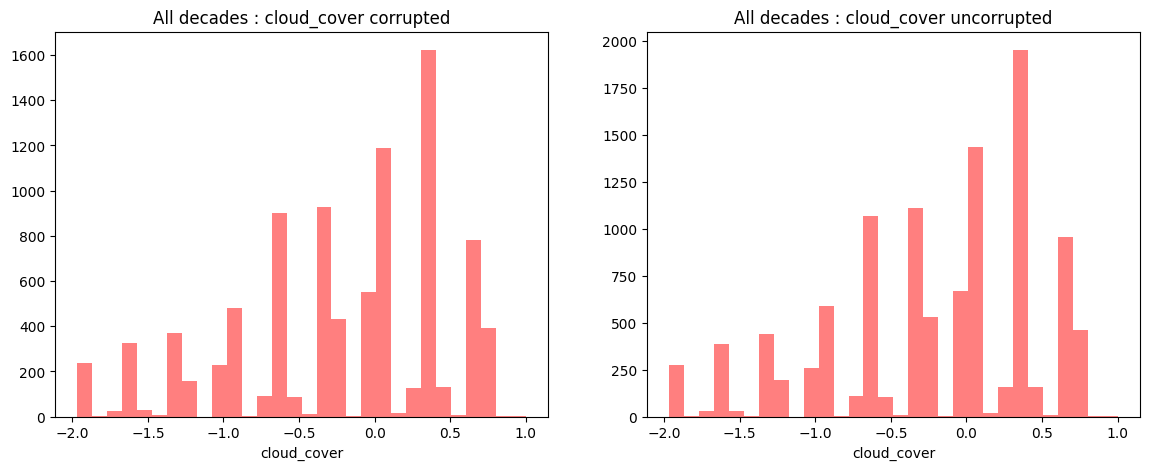

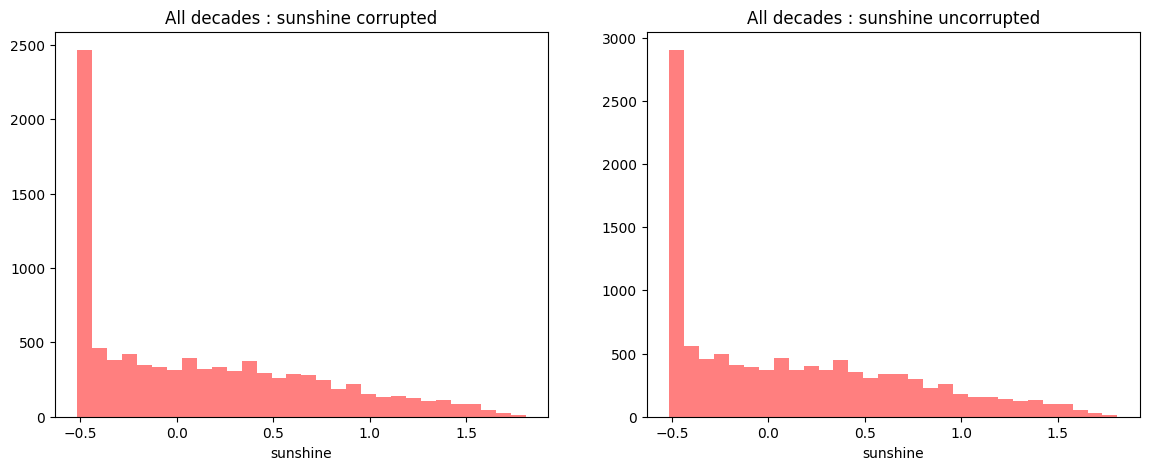

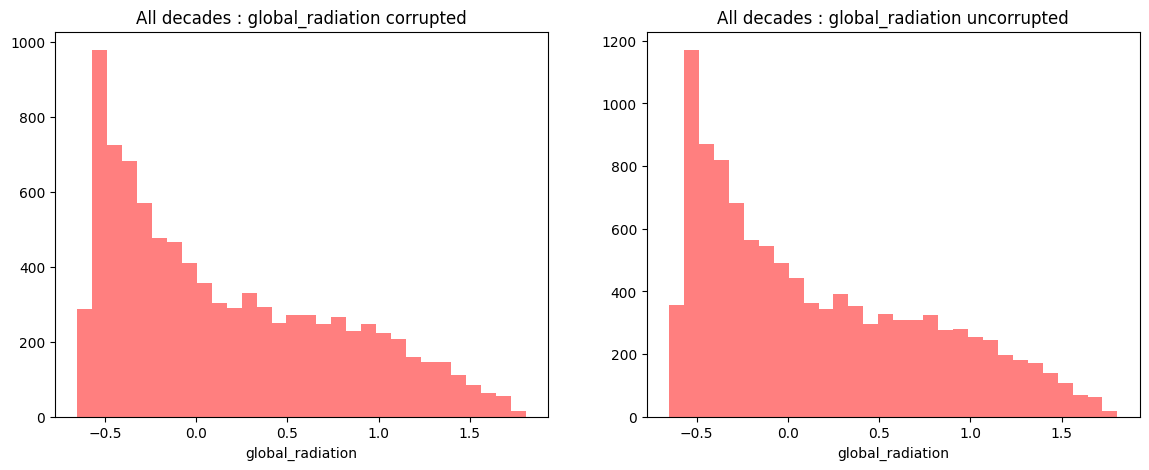

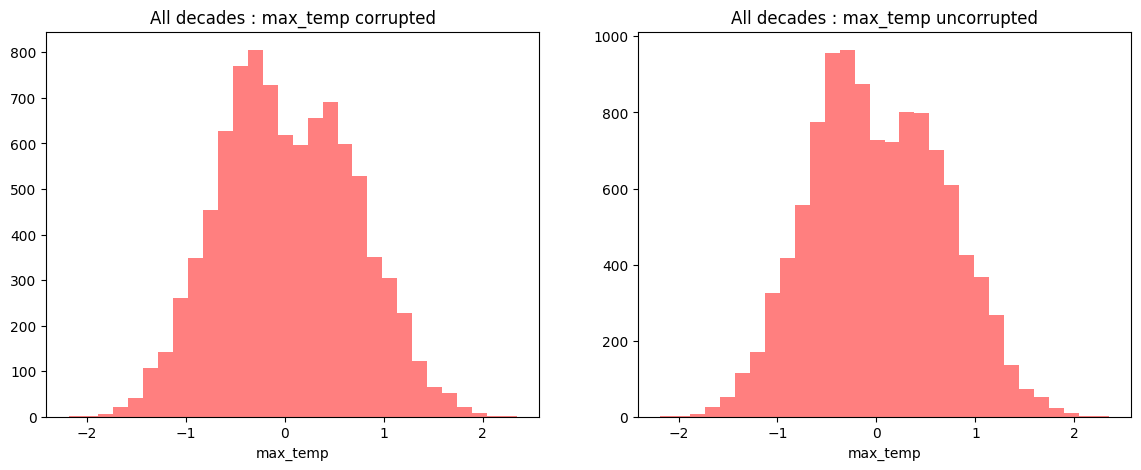

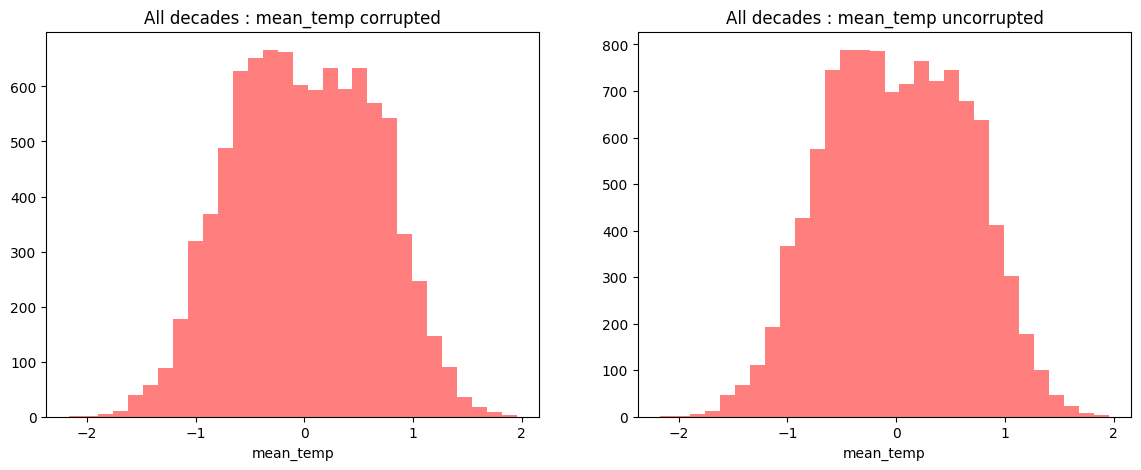

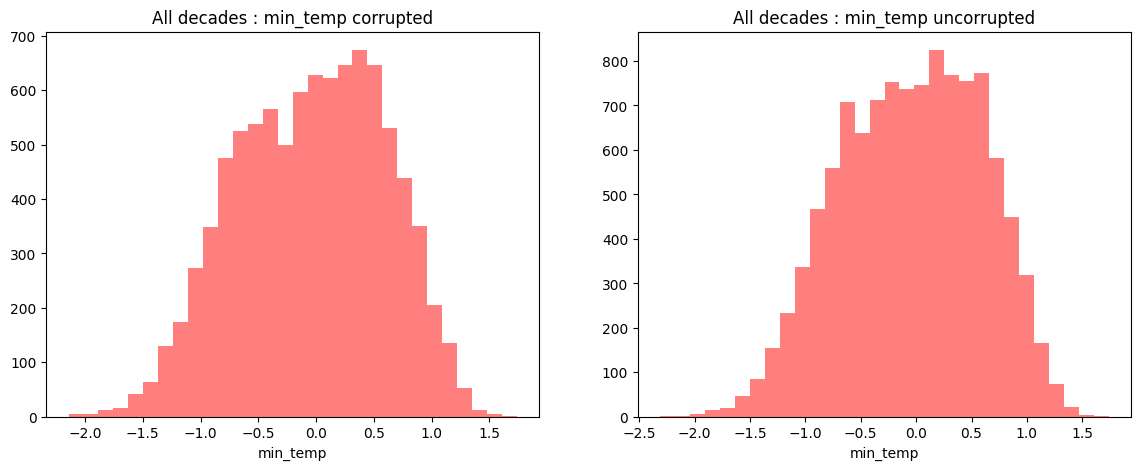

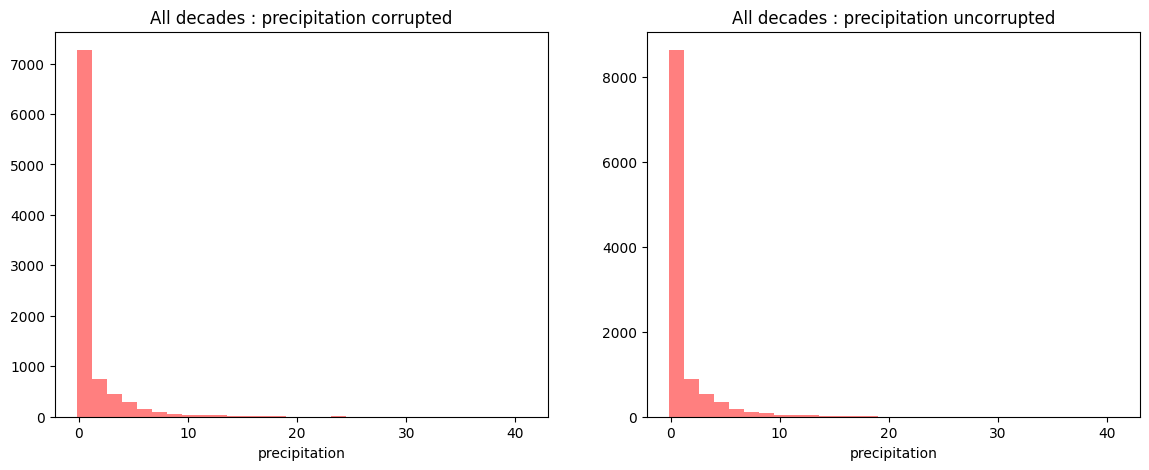

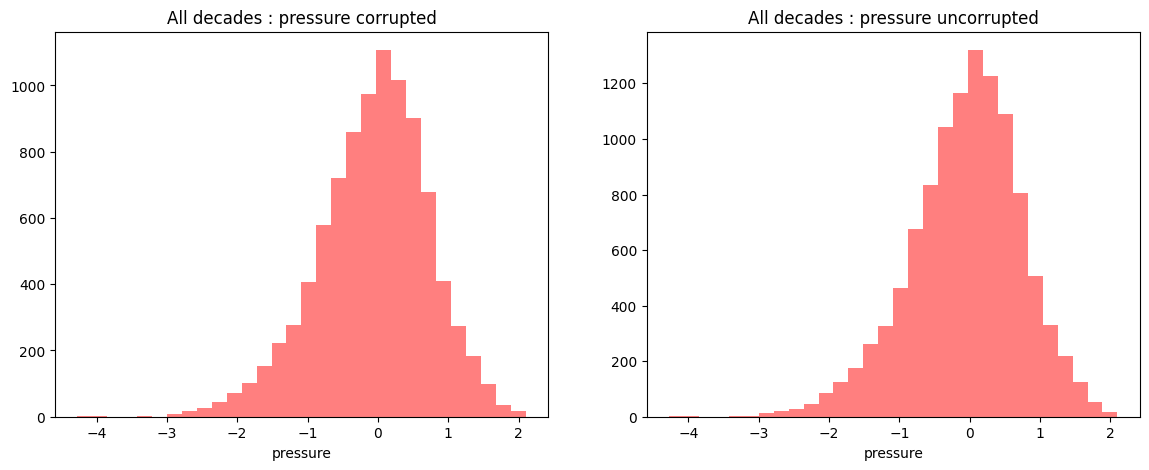

In [24]:
columns = list(training_set[0].columns)


for column in list(columns):
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  variable = training_set_norm[column].to_numpy()
  plt.hist(variable, bins=30, alpha=0.5, label='Corrupted', color='red')
  plt.title(f'All decades : {column} corrupted')
  plt.xlabel(f'{column}')

  plt.subplot(1, 2, 2)
  variable2 = training_set_nogaps_norm[column].to_numpy()
  plt.hist(variable2, bins=30, alpha=0.5, label='Corrupted', color='red')
  plt.title(f'All decades : {column} uncorrupted')
  plt.xlabel(f'{column}')

plt.show()

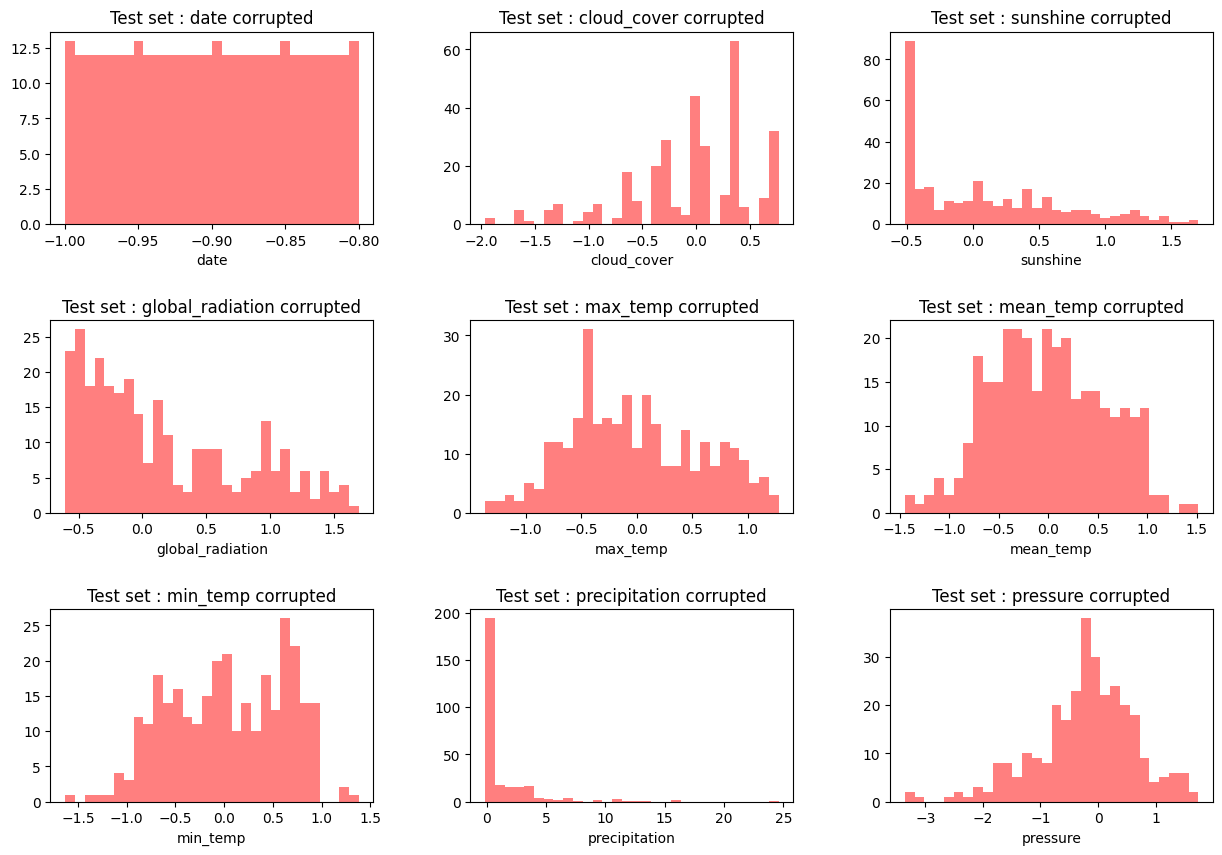

In [25]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns):
  plt.subplot(3, 3, i+1)
  variable = test_set_df_norm[column].iloc[:365].to_numpy()
  plt.hist(variable, bins=30, alpha=0.5, label='Corrupted', color='red')
  plt.title(f'Test set : {column} corrupted')
  plt.xlabel(f'{column}')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

### Correlation between days

I want to use a model that handles sequential data, so I need to understand the correlation between the days in order to determine how many days per sequence should be fed into the model.

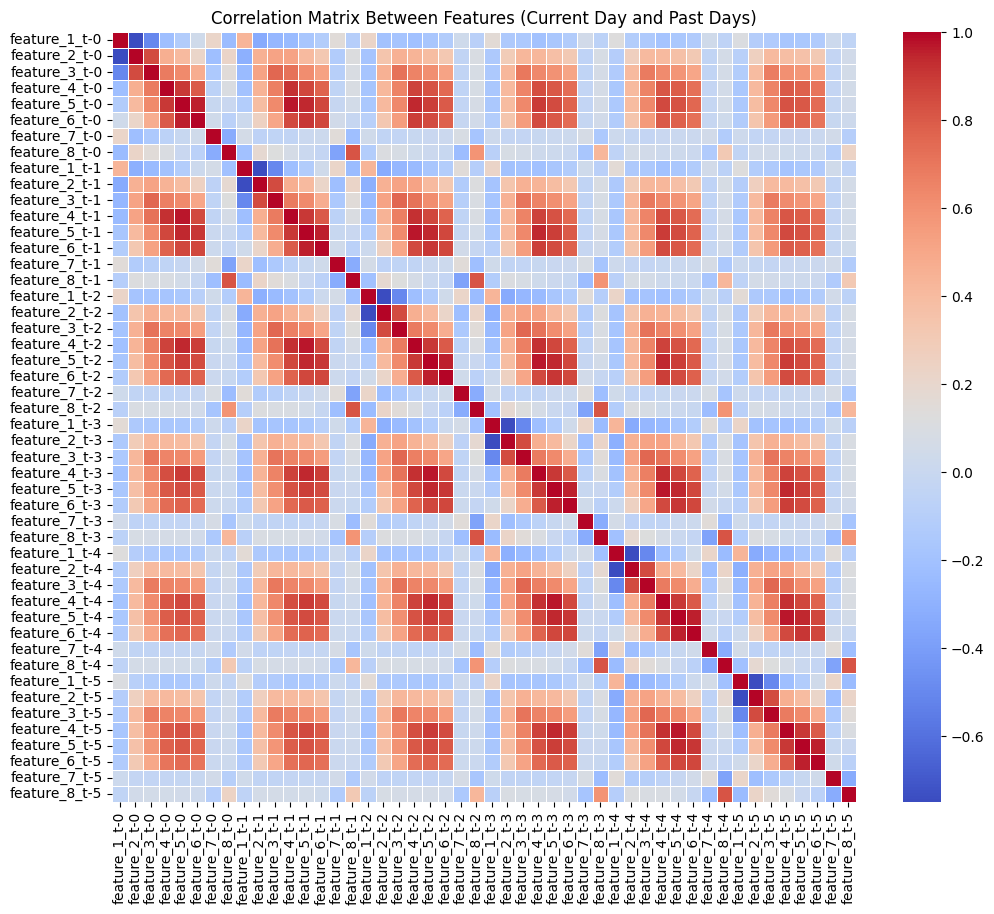

In [26]:
# Written by ChatGPT - Reference 1
def create_feature_matrix(df, seq_len=5):
    """
    Creates a feature matrix using the current day and previous days up to t-4.
    For example, given seq_len=5, the output will include columns from day t, t-1, t-2, t-3, t-4 for each feature.

    Args:
    - df: DataFrame containing the features.
    - seq_len: Sequence length for which we are checking correlations.

    Returns:
    - feature_matrix: DataFrame where each column represents the feature values from the current day and previous days.
    """
    feature_matrix = []

    # Iterate through the DataFrame to create sliding windows
    for i in range(seq_len, len(df)):
        window = []
        for j in range(seq_len):
            window.append(df.iloc[i - j].values)  # Take the values of the current day and previous days
        feature_matrix.append(np.concatenate(window))  # Concatenate all rows into one vector

    # Convert to DataFrame for easier manipulation
    # Now we correctly assign column names with the appropriate feature and time step
    column_names = []
    for j in range(seq_len):
        for i in range(df.shape[1]):
            column_names.append(f'feature_{i+1}_t-{j}')

    feature_matrix_df = pd.DataFrame(feature_matrix, columns=column_names)

    return feature_matrix_df

def calculate_correlation_matrix(df, seq_len=5):
    """
    Calculates the correlation matrix of the current day features and the past `seq_len` days features.

    Args:
    - df: DataFrame containing the training labels (features).
    - seq_len: Number of past days to consider for correlation (e.g., 5 for t, t-1, t-2, ... t-4).

    Returns:
    - correlation_matrix: A correlation matrix showing correlations between features.
    """
    # Create the feature matrix using the specified sequence length
    feature_matrix = create_feature_matrix(df, seq_len)

    # Calculate the correlation matrix
    correlation_matrix = feature_matrix.corr()

    return correlation_matrix

def plot_correlation_matrix(correlation_matrix):
    """
    Plots the correlation matrix using seaborn's heatmap.

    Args:
    - correlation_matrix: The correlation matrix to be plotted.
    """
    plt.figure(figsize=(12, 10))  # Increase figure size for better readability
    sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix Between Features (Current Day and Past Days)')
    plt.show()

np.random.seed(42)
seq_len = 6

# Calculate correlation matrix
correlation_matrix = calculate_correlation_matrix(training_set_labels.drop(columns='date'), seq_len)

# Plot the correlation matrix
plot_correlation_matrix(correlation_matrix)


The matrix shows that features across days are highly correlated, particularly for features 2 to 6. Additionally, the correlation decreases as the gap between days increases. Since testing different sequence lengths (`seq_len`) is time-consuming, I will use the first four days for training, as they exhibit the strongest correlations : `seq_len = 4`

### Padding

I am adding padding at the beginning and end of my training and test sets because I am slicing them into sequential batches of size (`batch_size`, `seq_len`, 9). Without this padding, certain rows at the beginning or end of my dataframe would be excluded from training and testing, depending on the value of `seq_len`.

In [27]:
seq_len = 4 # that will be feed into the model (RNN)

def pad_dataframe(df_data, seq_len):
    padding_start = pd.DataFrame(0, columns=df_data.columns, index=range(seq_len-1))

    padding_end = pd.DataFrame(0, columns=df_data.columns, index=range(seq_len-3))
    padded_df = pd.concat([padding_start, df_data, padding_end], ignore_index=True)

    padded_df = padded_df.reset_index(drop=True)
    return padded_df

In [28]:
padded_train_data = pad_dataframe(training_set_norm, seq_len)
padded_train_labels = pad_dataframe(training_set_nogaps_norm, seq_len)
padded_test_data = pad_dataframe(test_set_df_norm, seq_len)

padded_train_data.head(8)

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  0.000000     0.000000  0.000000          0.000000  0.000000   0.000000   
1  0.000000     0.000000  0.000000          0.000000  0.000000   0.000000   
2  0.000000     0.000000  0.000000          0.000000  0.000000   0.000000   
3 -0.999589    -0.633333 -0.485294         -0.580936 -1.326531  -1.415730   
4 -0.999041    -1.300000  0.470588         -0.246794 -0.377551  -1.505618   
5 -0.998494     0.666667 -0.514706         -0.614905 -0.561224        NaN   
6 -0.997946    -0.333333  0.088235         -0.369497 -0.724490        NaN   
7 -0.997398    -0.666667 -0.323529         -0.519237 -0.683673        NaN   

   min_temp  precipitation  pressure  
0  0.000000       0.000000  0.000000  
1  0.000000       0.000000  0.000000  
2  0.000000       0.000000  0.000000  
3 -1.428571      -0.133333 -0.258086  
4 -1.642857       0.000000  0.620171  
5 -1.619048       6.466667  0.219377  
6 -0.833333      -0.133333 -0.887916  
7 -0.726190      -0.133333 -0.750374

In my dataset, I will also return a `mask` tensor to indicate to the model what are the missing values: `mask == 0` for the non-missing values and `mask == 1`  for the missing values.

In [ ]:
# Help of ChatGPT to improve this section - Reference 2

class CustomDataset(Dataset):
    def __init__(self, df_data, df_label=None, seq_len=5, transform=None, interpolation_method='linear'):
        self.df_data = df_data.reset_index(drop=True)  # Reset index to avoid issues with non-sequential index
        self.df_label = df_label
        self.seq_len = seq_len
        self.transform = transform
        self.interpolation_method = interpolation_method

    def __len__(self):
        return len(self.df_data) - self.seq_len

    def __getitem__(self, idx):
        data_sequence = self.df_data.iloc[idx:idx + self.seq_len]

        mask_sequence = (data_sequence.isna()).astype(float)

        data_sequence_interpolated = data_sequence.interpolate(method=self.interpolation_method, axis=0)
        data_sequence_interpolated = data_sequence_interpolated.bfill().ffill()
        data_sequence_interpolated = data_sequence_interpolated.fillna(0)

        data_sequence_interpolated = data_sequence_interpolated.values.astype(float)

        if self.df_label is not None:
            label_sequence = self.df_label.iloc[idx: idx + self.seq_len].values.astype(float)
        else:
            label_sequence = None

        if self.transform:
            data_sequence_interpolated = self.transform(data_sequence_interpolated)
            mask_sequence = self.transform(mask_sequence)
            if label_sequence is not None:
                label_sequence = self.transform(label_sequence)

        if label_sequence is not None:
            return (torch.tensor(data_sequence_interpolated, dtype=torch.float32),
                    torch.tensor(mask_sequence.values, dtype=torch.float32),
                    torch.tensor(label_sequence, dtype=torch.float32))
        else:
            return (torch.tensor(data_sequence_interpolated, dtype=torch.float32),
                    torch.tensor(mask_sequence.values, dtype=torch.float32))





In [30]:
training_dataset = CustomDataset(padded_train_data, padded_train_labels, seq_len=seq_len)
test_dataset = CustomDataset(padded_test_data, seq_len=seq_len)

# StackOverflow - Reference 3
valid_size = int(len(training_dataset) * 0.1)
training_size = len(training_dataset) - valid_size

train_dataset = torch.utils.data.Subset(training_dataset, range(training_size))
valid_dataset = torch.utils.data.Subset(training_dataset, range(training_size, len(training_dataset)))


batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
len(train_loader)

155

In [32]:
data, mask, labels = next(iter(train_loader))


In [33]:
data.shape

torch.Size([64, 4, 9])

In [34]:
labels.shape

torch.Size([64, 4, 9])

In [35]:
mask.shape

torch.Size([64, 4, 9])

In [36]:

input = []
label = []
for i in range(data.shape[0]):
  input.append(data[i, -1, :].numpy().tolist()) # we take the last day of the sequence for each element in the batch
  label.append(labels[i, -1, :].numpy().tolist())

input = torch.tensor(np.array(input))
label = torch.tensor(np.array(label))
input.shape

torch.Size([64, 9])

### Plotting of one batch

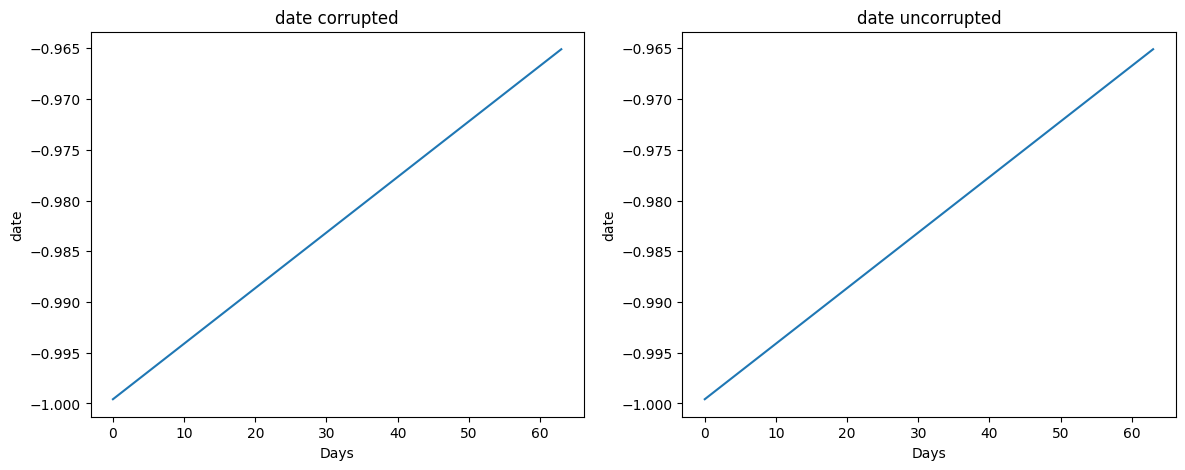

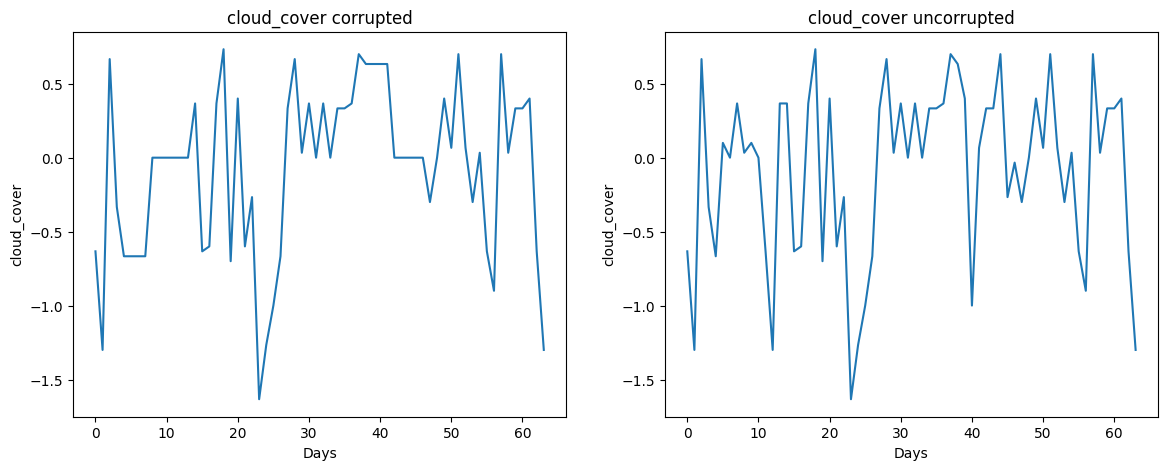

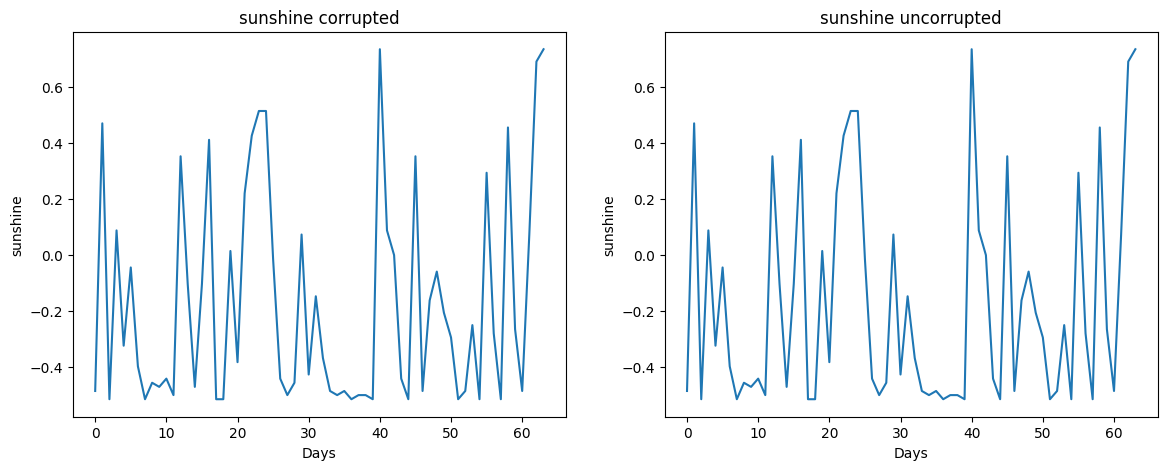

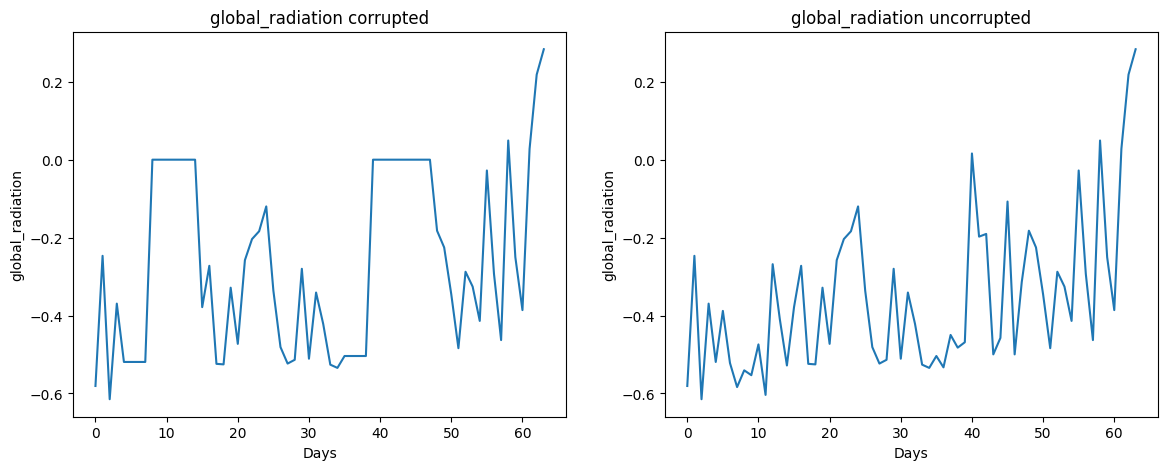

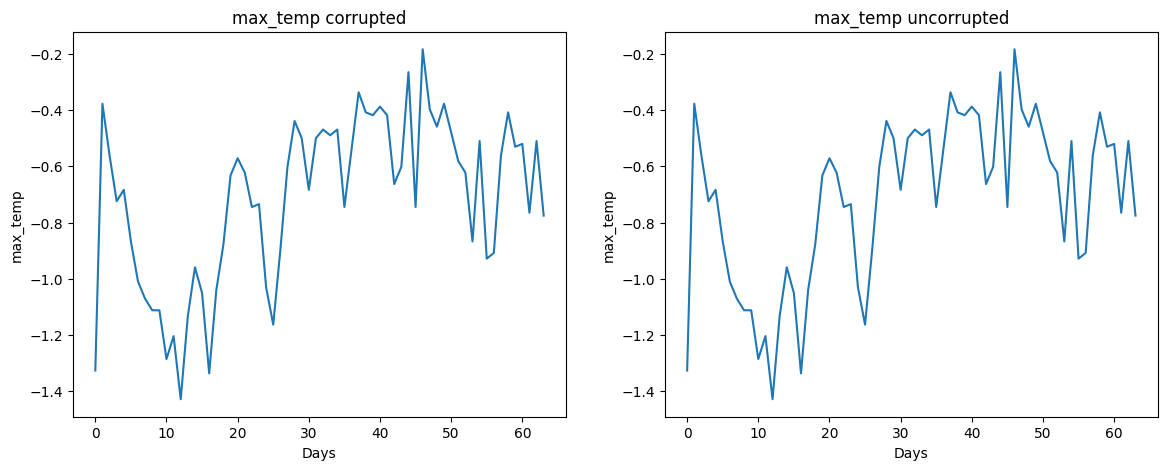

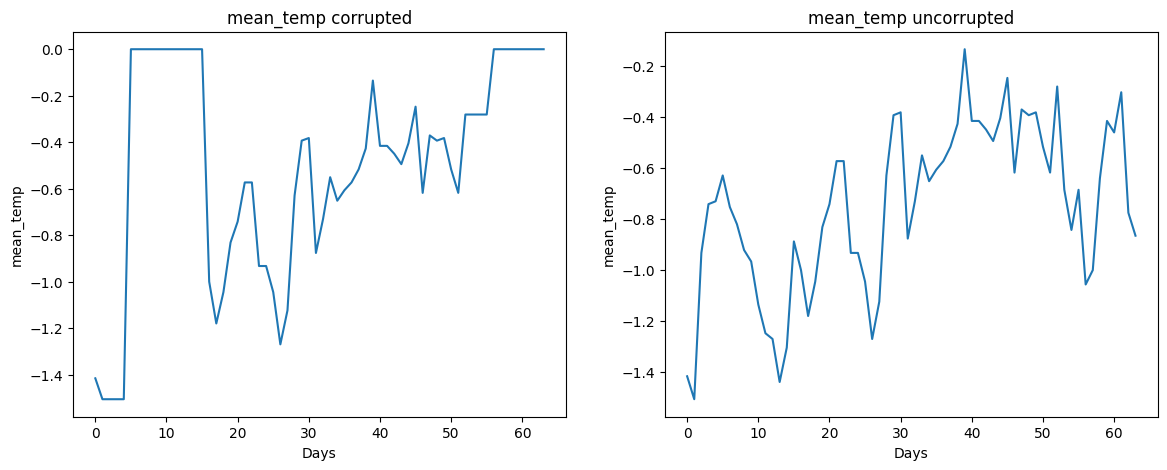

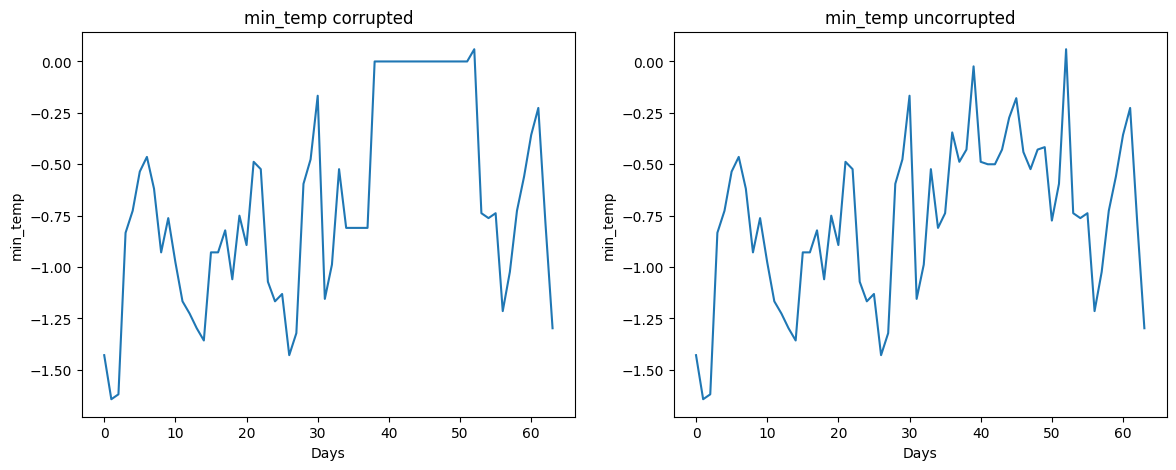

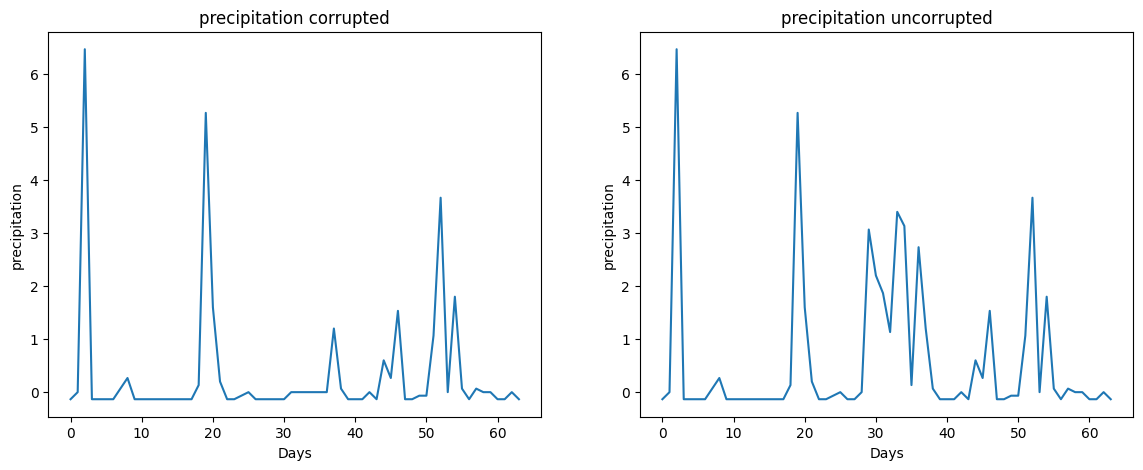

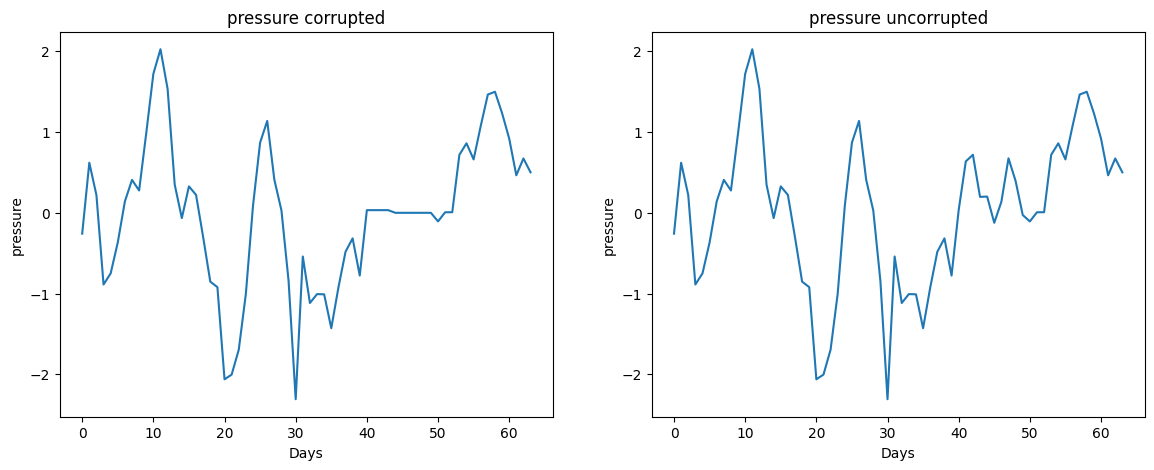

In [37]:

for col, j in zip(columns, range(input.shape[1])):
  plt.figure(figsize=(14, 5))
  plt.subplot(1, 2, 1)
  variable = input[:, j].numpy()
  plt.plot(variable)
  plt.title(f'{col} corrupted')
  plt.xlabel('Days')
  plt.ylabel(f'{col}')

  plt.subplot(1, 2, 2)
  variable = label[:,j].numpy()
  plt.plot(variable)
  plt.title(f'{col} uncorrupted')
  plt.xlabel('Days')
  plt.ylabel(f'{col}')

plt.show()

In [38]:
testdata, mask = next(iter(test_loader))
testdata.shape

torch.Size([64, 4, 9])

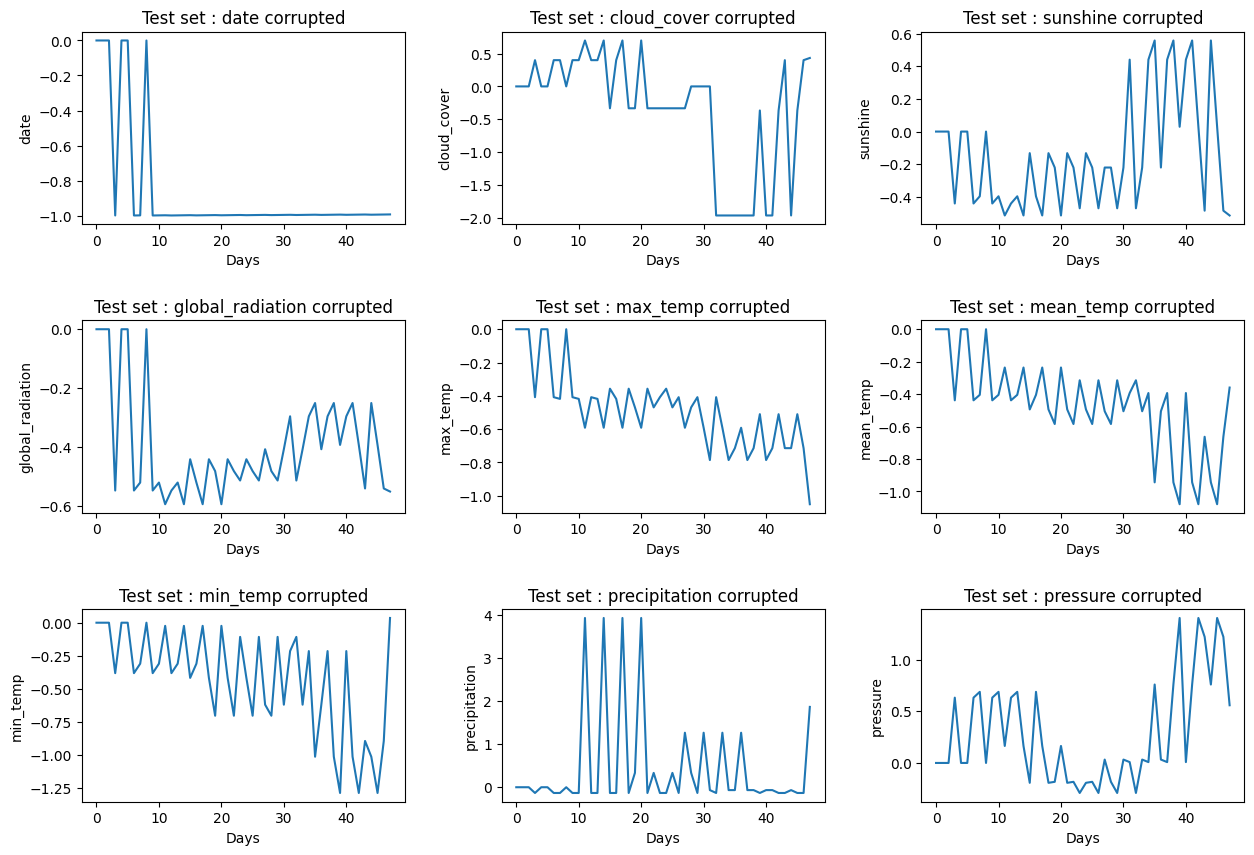

In [39]:

num = 12
input = []
for i in range(num):
  input += testdata[i].numpy().tolist()

input = torch.tensor(np.array(input))

plt.figure(figsize=(15, 10))

for col, j in zip(columns, range(input.shape[1])):
  plt.subplot(3, 3, j+1)
  variable = input[:,j].numpy()
  plt.plot(variable)
  plt.title(f'Test set : {col} corrupted')
  plt.xlabel('Days')
  plt.ylabel(f'{col}')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

<br>

---

<br>

## **Question 3** (50%)

Using the dataset created in **Question 2**, design and train an architecture to recover the missing weather values of the provided test dataset.

Using line plots, show the test weather data with the missing values filled in using a different colour.

Additionally, save the test data with the missing values filled in into a file called `test_set_nogaps.csv` inside this repository. This file should have the same format as the original `test_set.csv` file, with the same number of rows and columns, the same row and column ordering, and the same column headings.

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>


### RNN model using a LSTM cell

In [40]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [41]:
# The base of this model comes from the lecture 14-Recap
# and has been modified by ChatGTP and then I modified it a bit - Reference 4

class WeatherRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0 ,num_layers=1):
        super(WeatherRNN, self).__init__()

        self.rnn = nn.LSTM(input_size=input_size,  # Number of features per time step
                           hidden_size=hidden_size,  # Number of RNN units
                           num_layers=num_layers,  # Number of RNN layers
                           batch_first=True,  # Input format: (batch_size, seq_len, input_size)
                           dropout=dropout)
        self.fc = nn.Linear(hidden_size, input_size)  # Map RNN output back to feature space

    def forward(self, x, mask):

        # RNN output
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)

        # Map to input space
        output = self.fc(rnn_out)  # output: (batch_size, seq_len, input_size)

        output = output * mask + x * (1 - mask)


        return output


In [42]:
# ChatGPT help written this by correcting the error with required_grad=True - Reference 2/ Reference 5
def masked_loss(predictions, targets, mask, criterion):

    element_loss = criterion(predictions, targets)  # Shape: (batch_size, seq_len, num_features)

    masked_loss = element_loss * mask


    total_missing = mask.sum()
    if total_missing == 0:
        return torch.tensor(0.0, device=predictions.device, requires_grad=True)

    final_loss = masked_loss.sum() / (total_missing + 1e-8)

    return final_loss


In [43]:
def train(model, optimizer, criterion, loader, device):
    model.train()
    train_loss = 0
    for data, mask, label in loader:
        data, mask, label = data.to(device), mask.to(device), label.to(device)
        # print('label ', label)

        optimizer.zero_grad()
        predictions = model(data, mask)

        loss = masked_loss(predictions, label, mask, criterion)
        # print('loss ', loss.requires_grad)  # Should return True for a loss that is part of the graph
        # print('loss fn ', loss.grad_fn)
        loss.backward()

        train_loss += loss.item()

        optimizer.step()

    return train_loss / len(loader)



def validate(model, criterion, loader, device):
    model.eval()
    validation_loss = 0.
    for data, mask, label in loader:
        with torch.no_grad():
            data, mask, label = data.to(device), mask.to(device), label.to(device)
            predictions = model(data, mask)

            loss = masked_loss(predictions, label, mask, criterion)
            validation_loss += loss.item()

    return validation_loss / len(loader)


In [44]:
def train_loop(model, train_loader, criterion, lr, wd, n_epochs, device, valid_loader=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    liveloss = PlotLosses()

    for epoch in range(n_epochs):
        logs = {}

        # Train phase
        train_loss = train(model, optimizer, criterion, train_loader, device)
        logs['log_loss'] = train_loss

        if valid_loader:
          # Validation phase
          validation_loss = validate(model, criterion, valid_loader, device)
          logs['val_log_loss'] = validation_loss

        # Update the loss plot
        liveloss.update(logs)
        liveloss.draw()

        # Print the validation loss for the current epoch
        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss}")


In [45]:
hidden_size = 64
num_features = 9
num_layers = 2
dropout = 0.6
model = WeatherRNN(input_size=num_features, hidden_size=hidden_size, dropout=dropout, num_layers=num_layers).to(device)
print(model)

WeatherRNN(
  (rnn): LSTM(9, 64, num_layers=2, batch_first=True, dropout=0.6)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)


We input batches of sequences of length `seq_len` and the model has to predict these `seq_len` days and fill the missing values.

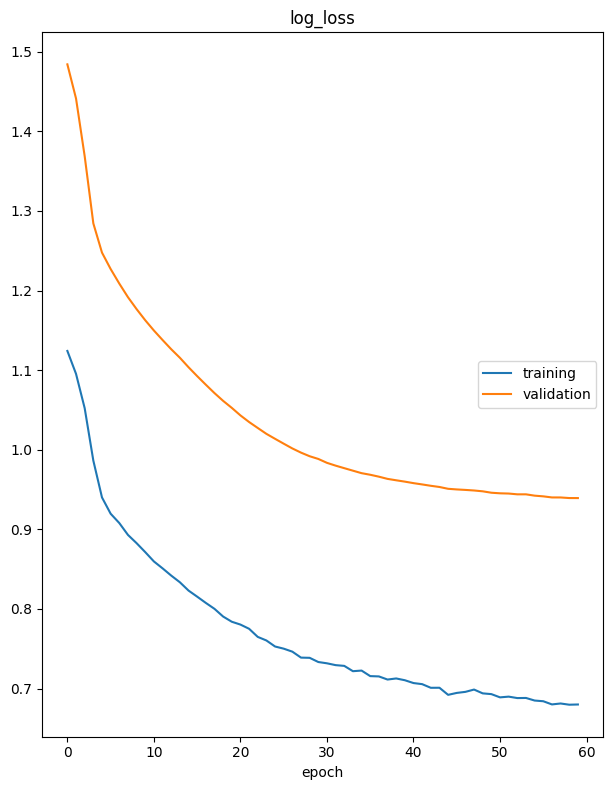

log_loss
	training         	 (min:    0.680, max:    1.124, cur:    0.680)
	validation       	 (min:    0.939, max:    1.484, cur:    0.939)
Epoch 60/60, Training Loss: 0.6800, Validation Loss: 0.9393062372174528


In [46]:
lr = 1e-4
weight_decay = 1e-5
n_epochs = 60
criterion = nn.MSELoss(reduction='none')


train_loop(model, train_loader, criterion, lr, weight_decay, n_epochs, device, valid_loader=valid_loader)

### Saving the trained model

In [47]:
model_save_name = 'LSTM_model.pt'
path = F"/content/drive/MyDrive/{model_save_name}"

torch.save(model.state_dict(), path)

In [48]:
model_save_name = 'LSTM_model.pt'
path = F"/content/drive/MyDrive/{model_save_name}"


hidden_size = 64
num_features = 9
num_layers = 2
dropout = 0.6
model_trained = WeatherRNN(input_size=num_features, hidden_size=hidden_size, dropout=dropout, num_layers=num_layers).to(device)
model_trained.load_state_dict(torch.load(path))

<ipython-input-48-7b470f2491b7>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_trained.load_state_dict(torch.load(path))


<All keys matched successfully>

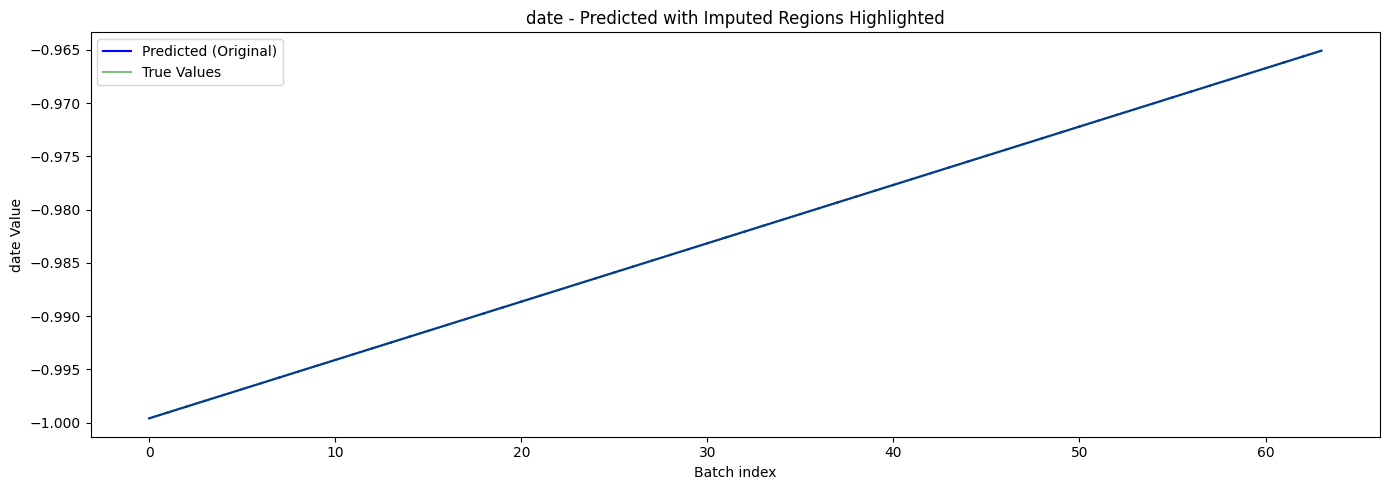

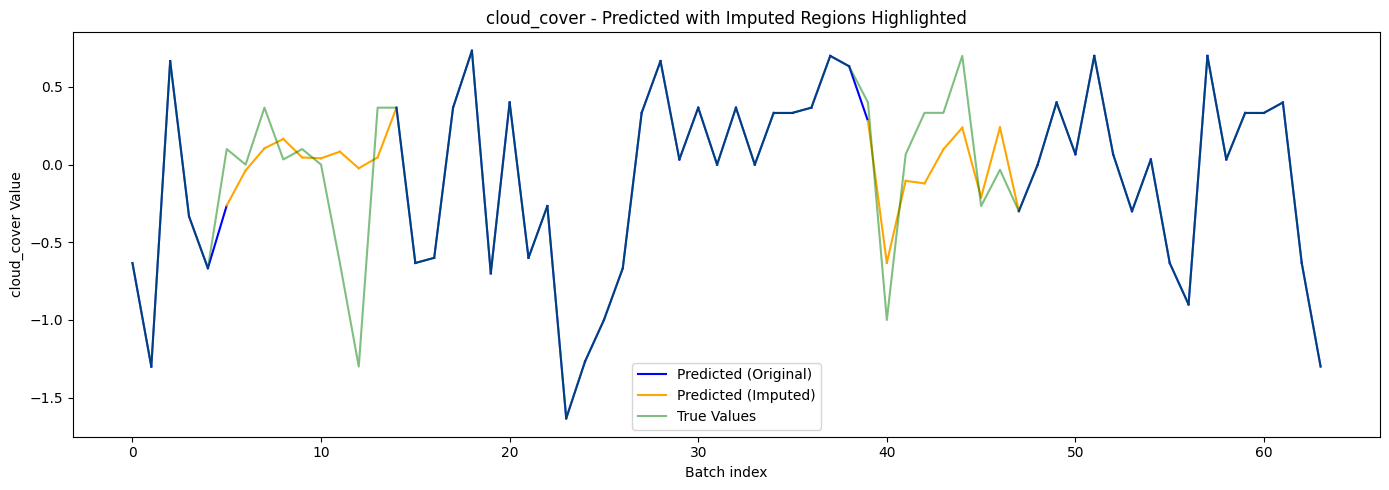

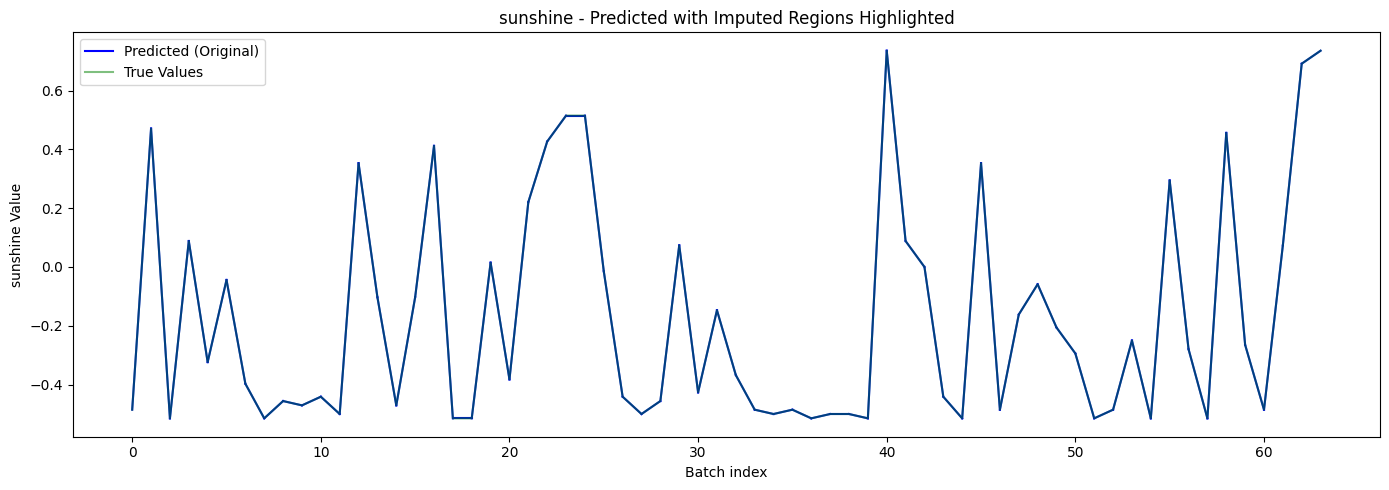

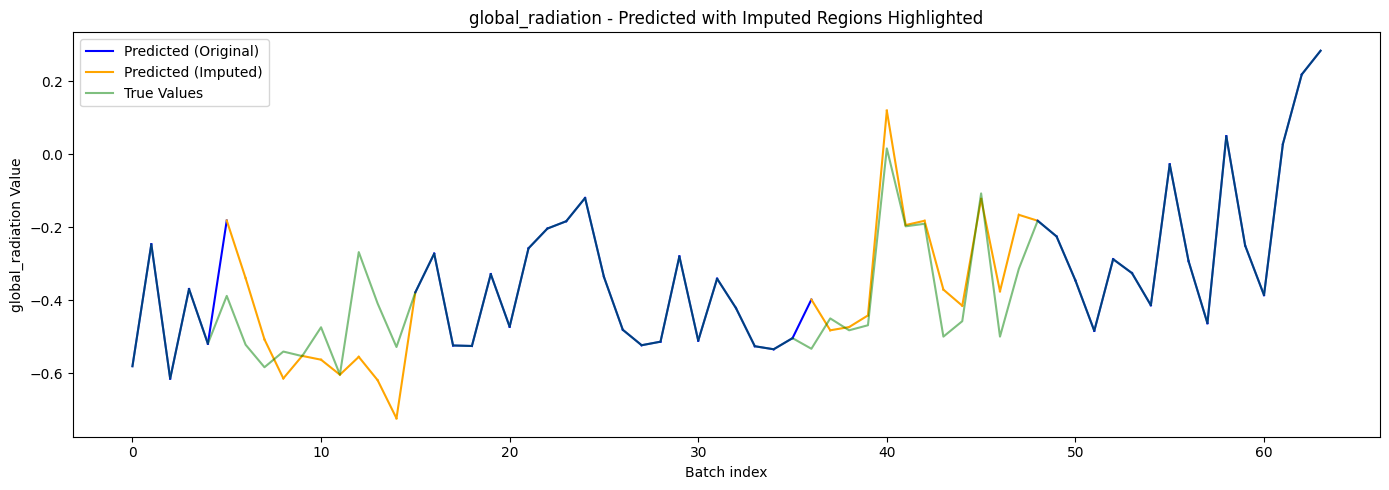

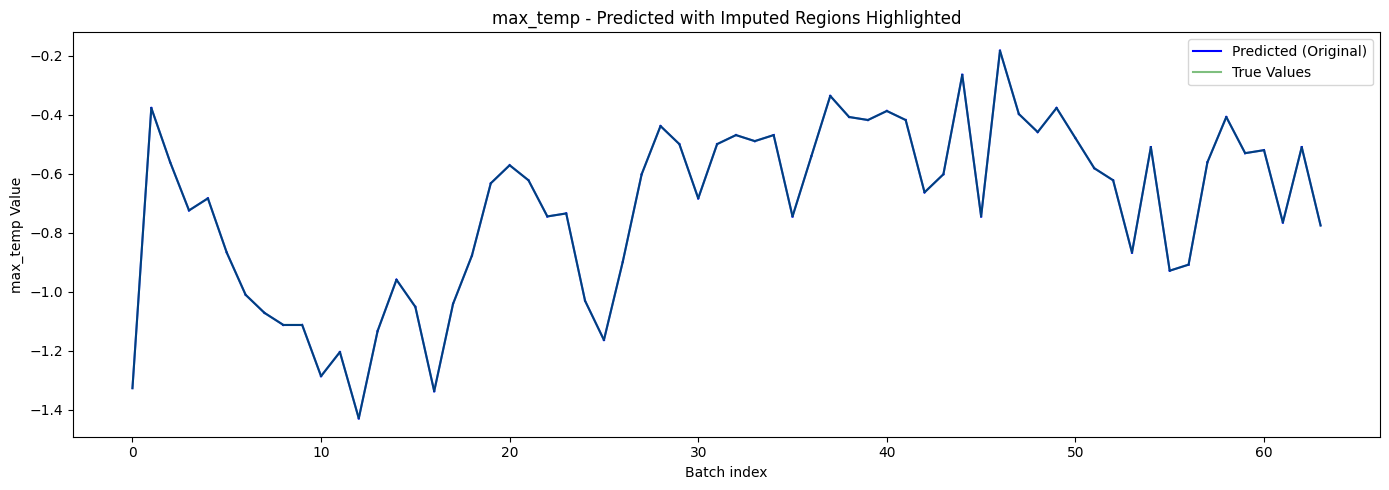

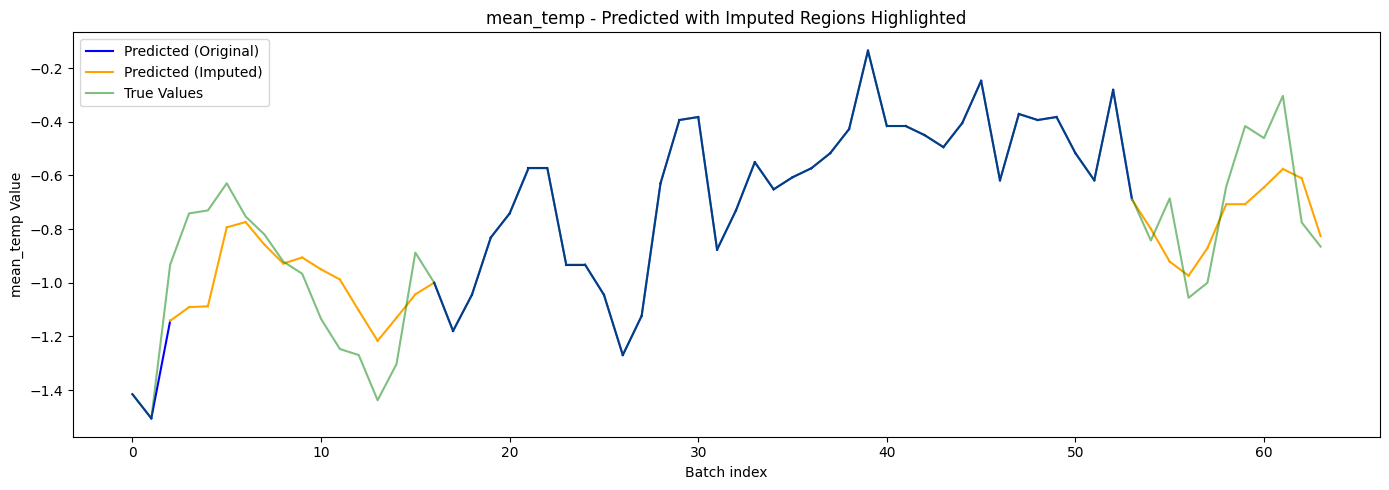

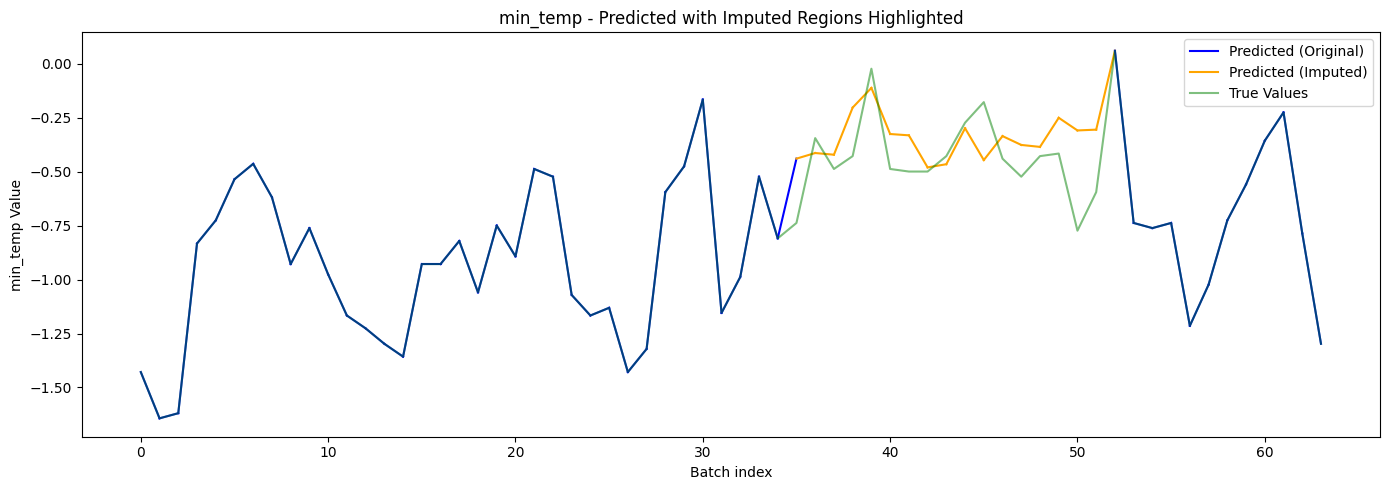

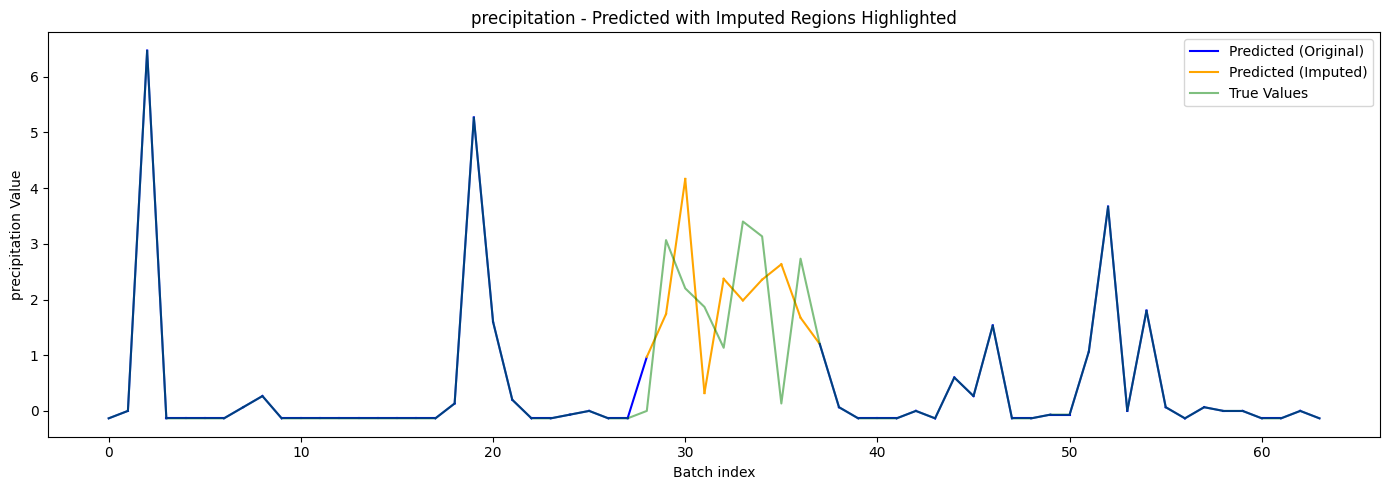

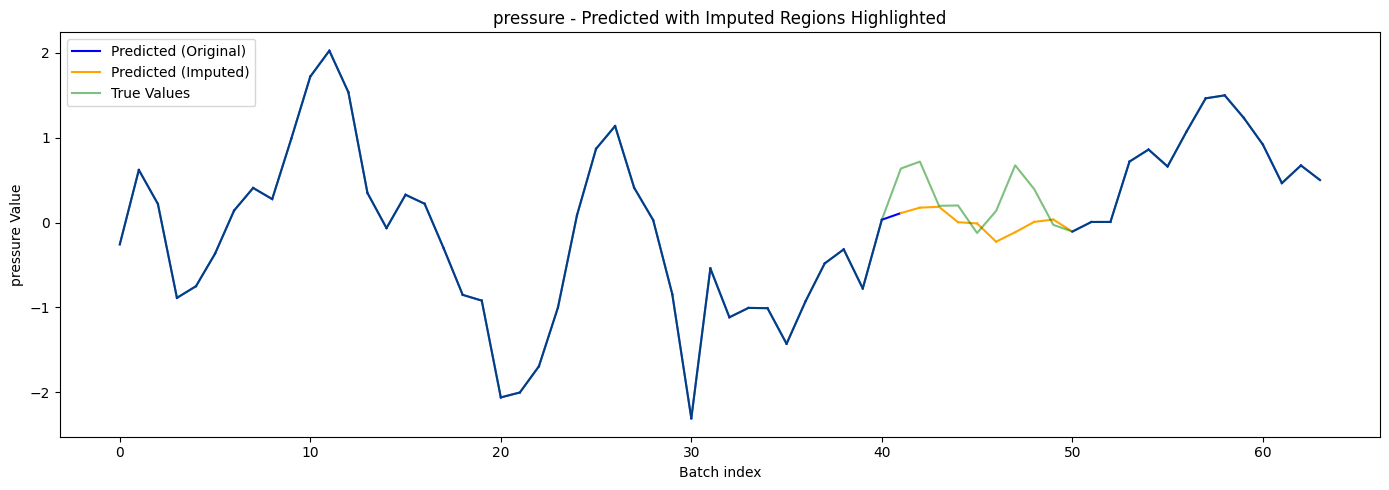

In [ ]:
# Help of ChatGPT to improve this section - Reference 6
model_trained.eval()

data, mask, labels = next(iter(train_loader))
data, mask = data.to(device), mask.to(device)
output = model_trained(data, mask)

output_list = []
label_list = []
mask_list = []

for i in range(data.shape[0]):
    output_list.append(output[i, -1, :].cpu().detach().numpy())
    label_list.append(labels[i, -1, :].detach().numpy())
    mask_list.append(mask[i, -1, :].cpu().detach().numpy())  # Add the mask values

output = torch.tensor(np.array(output_list))
label = torch.tensor(np.array(label_list))
mask = torch.tensor(np.array(mask_list))

# Create the plots for each column
for col, j in zip(columns, range(output.shape[1])):
    plt.figure(figsize=(14, 5))

    # Predicted (output) with combined coloring
    variable = output[:, j].numpy()
    mask_variable = mask[:, j].numpy()
    x_values = np.arange(len(variable))

    # Initialize the legend elements
    blue_legend = False
    orange_legend = False

    for i in range(len(variable) - 1):
        # Plot each segment of the curve in different colors based on the mask
        if mask_variable[i] == 1:
            color = 'orange'
            if not orange_legend:
                plt.plot([], [], color='orange', label='Predicted (Imputed)')
                orange_legend = True
        else:
            color = 'blue'
            if not blue_legend:
                plt.plot([], [], color='blue', label='Predicted (Original)')
                blue_legend = True
        plt.plot(x_values[i:i+2], variable[i:i+2], color=color)

    plt.title(f'{col} - Predicted with Imputed Regions Highlighted')
    plt.xlabel('Batch index')
    plt.ylabel(f'{col} Value')

    # Ground Truth (labels)
    plt.plot(label[:, j].numpy(), color='green', alpha=0.5, label="True Values")
    plt.legend()

    # Show the plots for the current column
    plt.tight_layout()
    plt.show()


In [50]:
# written withe the help of ChatGPT - Reference 6
def reverse_normalization(predictions, scaler, columns):
    predictions_reversed = scaler.inverse_transform(predictions)

    predictions_reversed = pd.DataFrame(predictions_reversed, columns=columns)

    return predictions_reversed

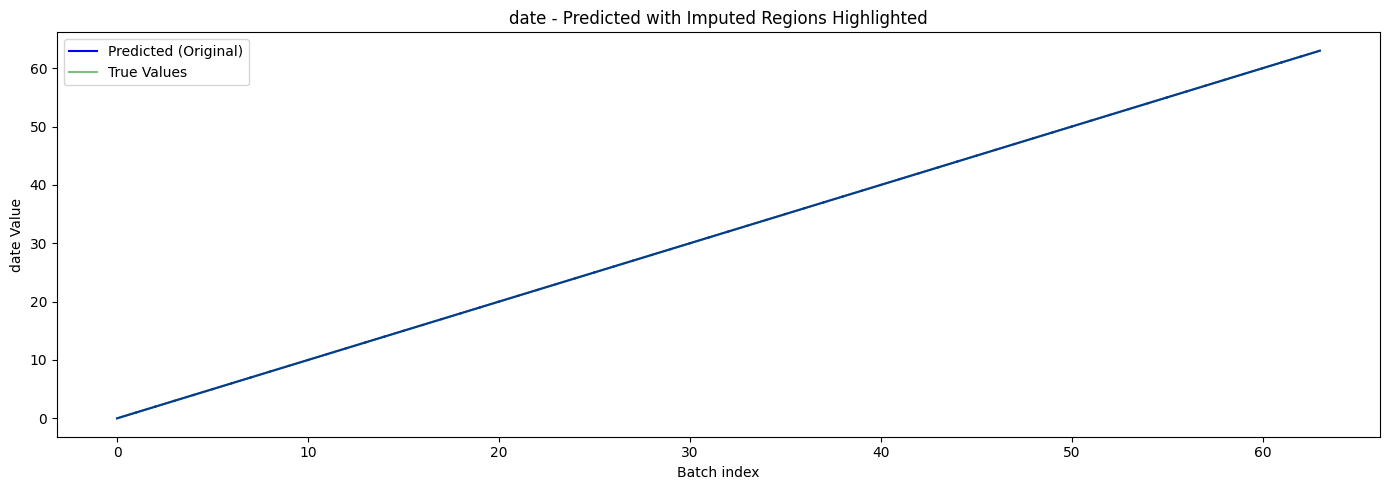

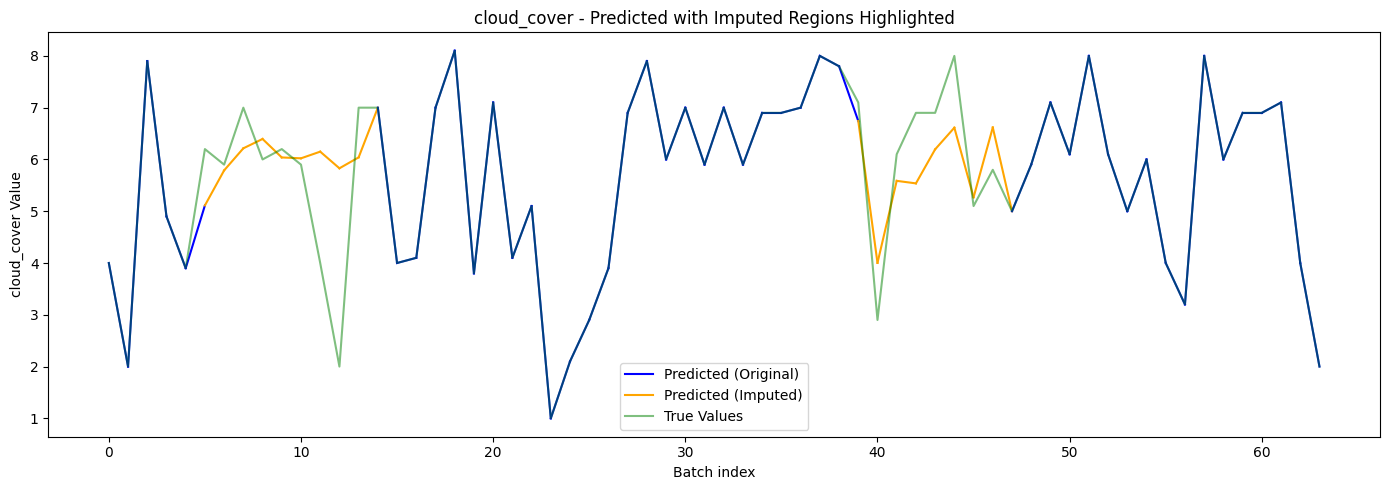

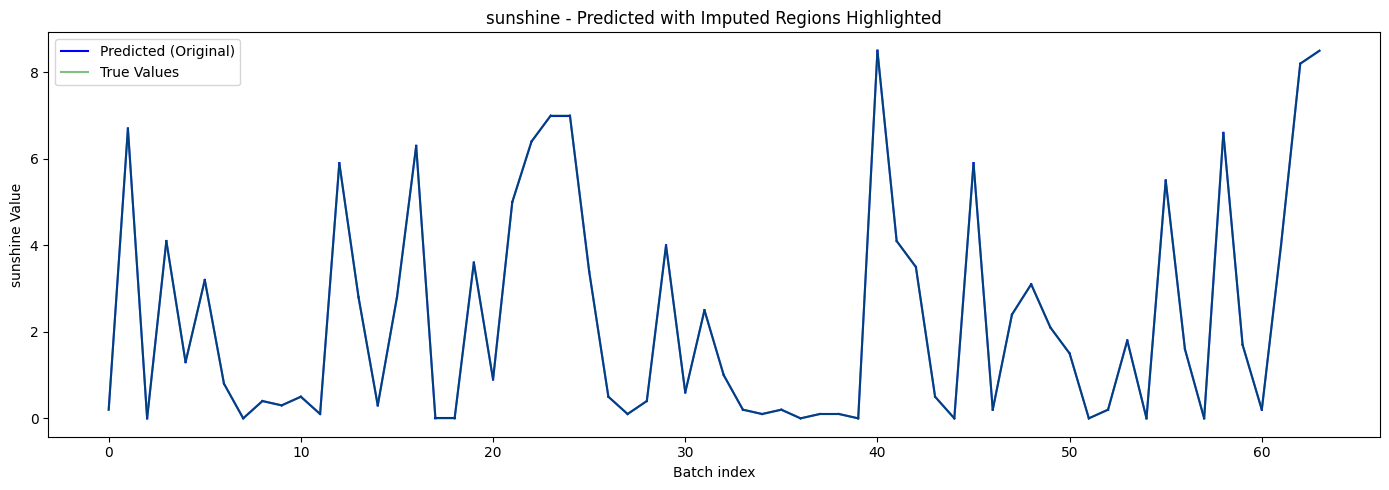

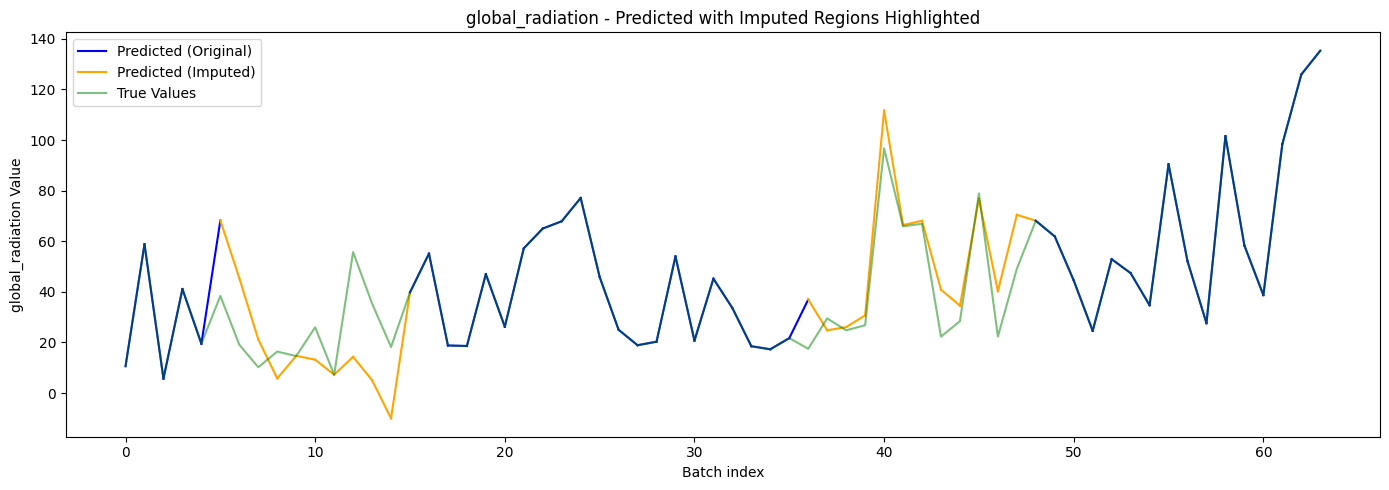

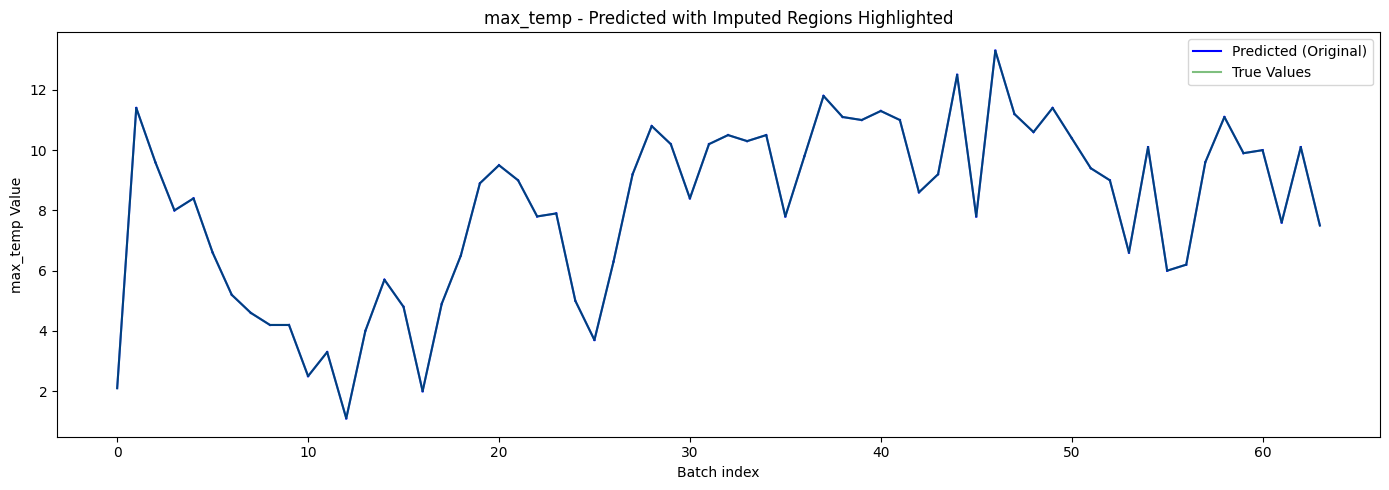

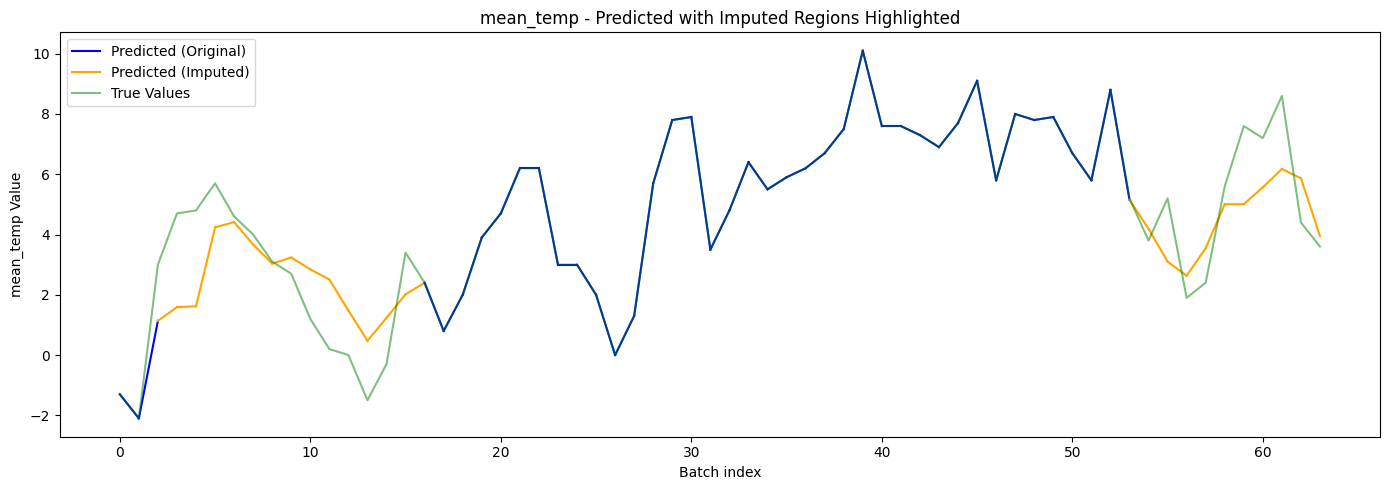

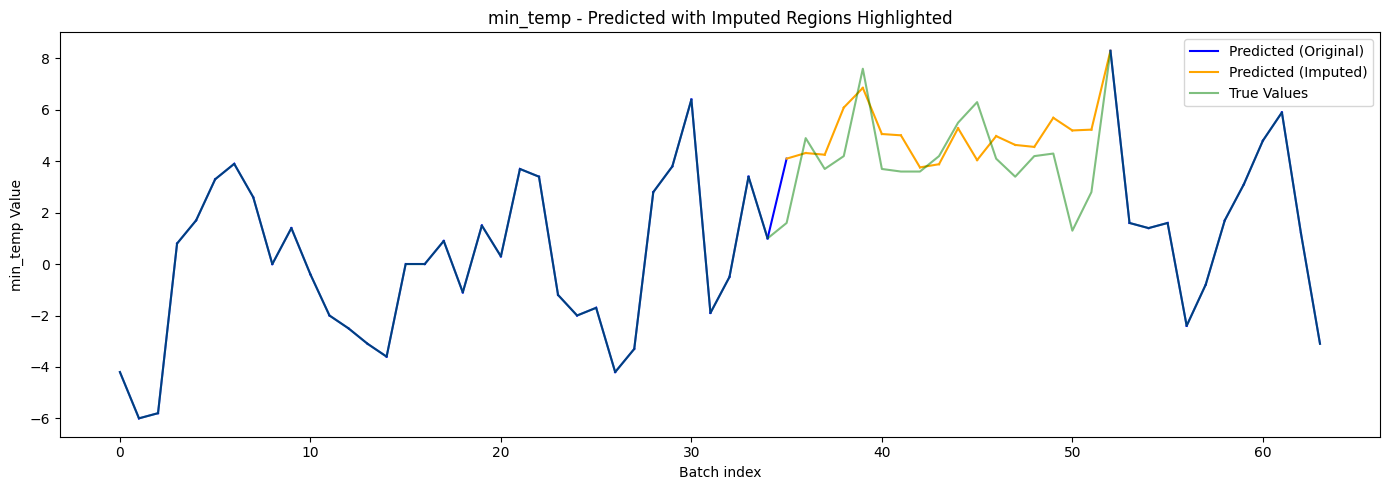

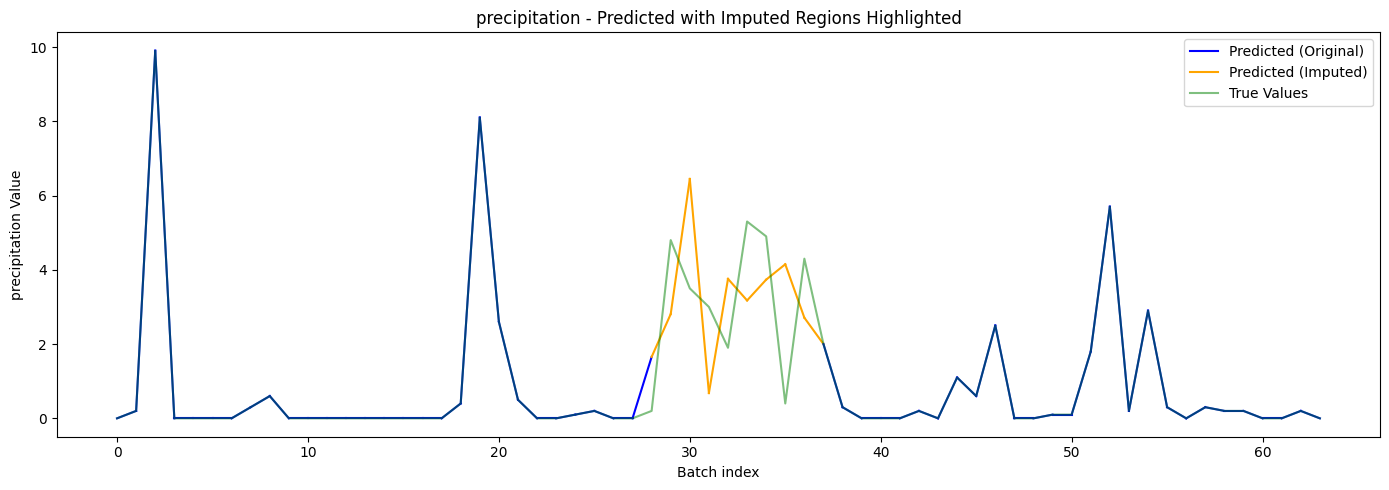

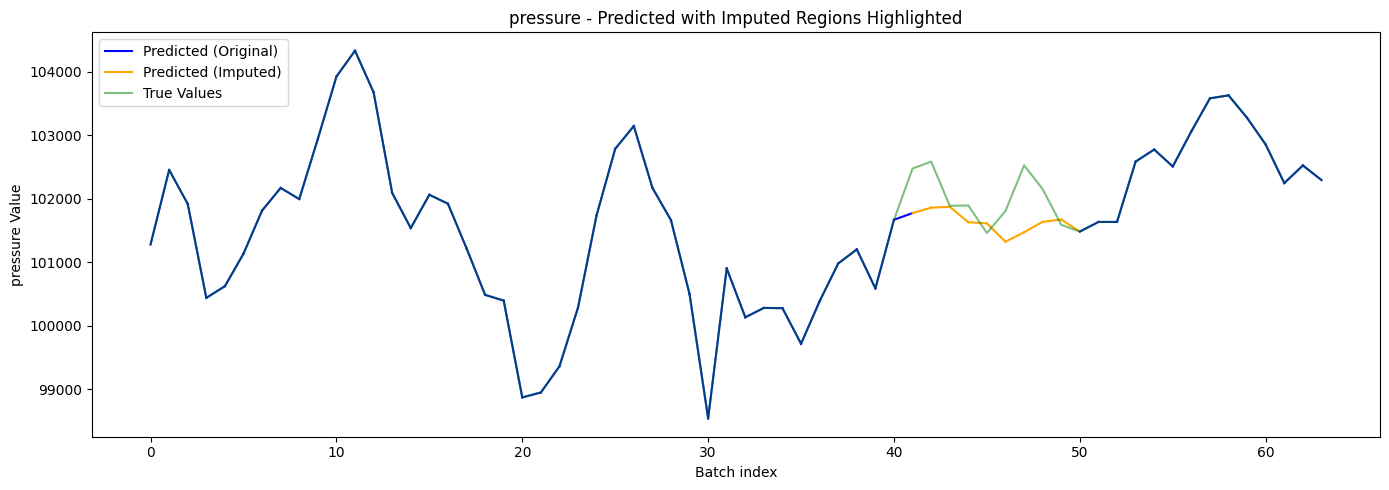

In [ ]:
# Help of ChatGPT to improve this section - Reference 6
model_trained.eval()

# Get a batch of data
data, mask, labels = next(iter(train_loader))
data, mask = data.to(device), mask.to(device)

# Model predictions
output = model_trained(data, mask)

# Prepare to reverse normalization
output_list = []
label_list = []
mask_list = []

for i in range(data.shape[0]):
    output_list.append(output[i, -1, :].cpu().detach().numpy())
    label_list.append(labels[i, -1, :].detach().numpy())
    mask_list.append(mask[i, -1, :].cpu().detach().numpy())  # Add the mask values

# Combine outputs into tensors
output = np.array(output_list)  # (batch_size, num_features)
label = np.array(label_list)    # (batch_size, num_features)
mask = np.array(mask_list)      # (batch_size, num_features)

# Reverse normalization for predictions and labels
output_reversed = reverse_normalization(output, scaler, columns)
label_reversed = training_set_labels.iloc[:len(label)]  # Retrieve corresponding rows

# Create the plots for each column
for col, j in zip(training_set_concat.columns, range(output.shape[1])):
    plt.figure(figsize=(14, 5))

    # Predicted (output) with combined coloring
    variable = output_reversed[col].values
    mask_variable = mask[:, j]  # Mask for the column
    x_values = np.arange(len(variable))

    # Initialize the legend elements
    blue_legend = False
    orange_legend = False

    for i in range(len(variable) - 1):
        # Plot each segment of the curve in different colors based on the mask
        if mask_variable[i] == 1:
            color = 'orange'
            if not orange_legend:
                plt.plot([], [], color='orange', label='Predicted (Imputed)')  # Add legend entry
                orange_legend = True
        else:
            color = 'blue'
            if not blue_legend:
                plt.plot([], [], color='blue', label='Predicted (Original)')  # Add legend entry
                blue_legend = True
        plt.plot(x_values[i:i+2], variable[i:i+2], color=color)

    plt.title(f'{col} - Predicted with Imputed Regions Highlighted')
    plt.xlabel('Batch index')
    plt.ylabel(f'{col} Value')

    # Ground Truth (labels)
    plt.plot(label_reversed[col].values, color='green', alpha=0.5, label="True Values")
    plt.legend()

    # Show the plots for the current column
    plt.tight_layout()
    plt.show()


### Let's predict on the test dataset

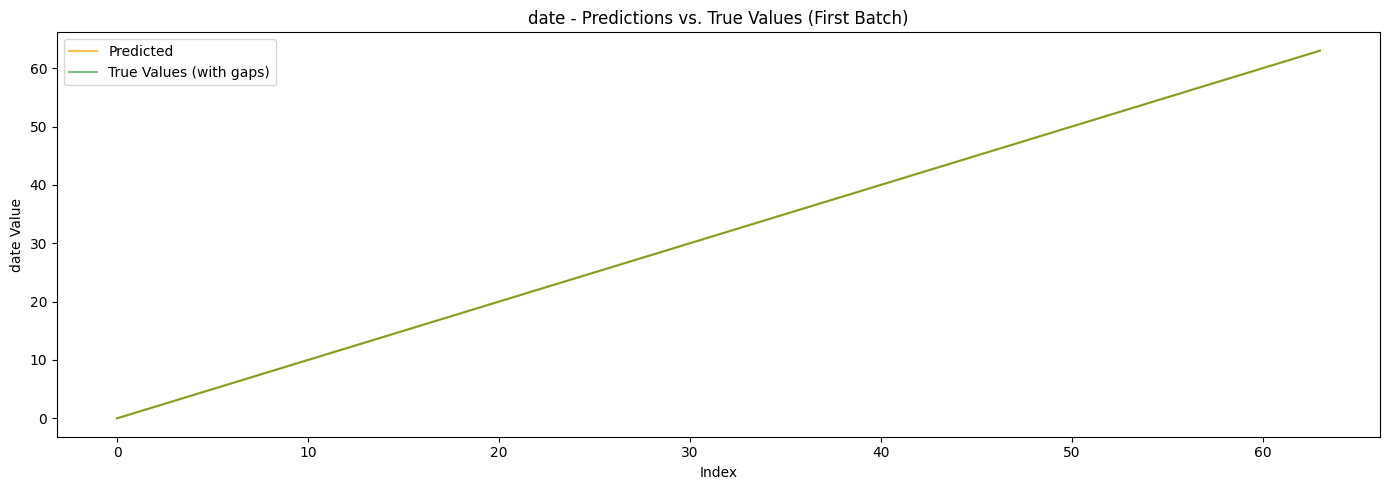

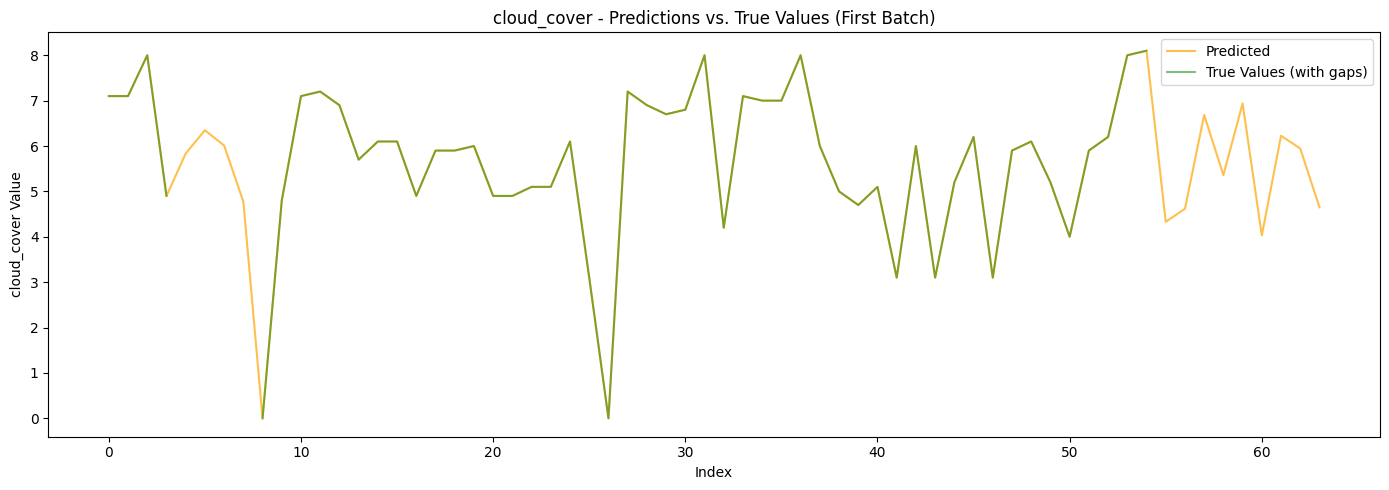

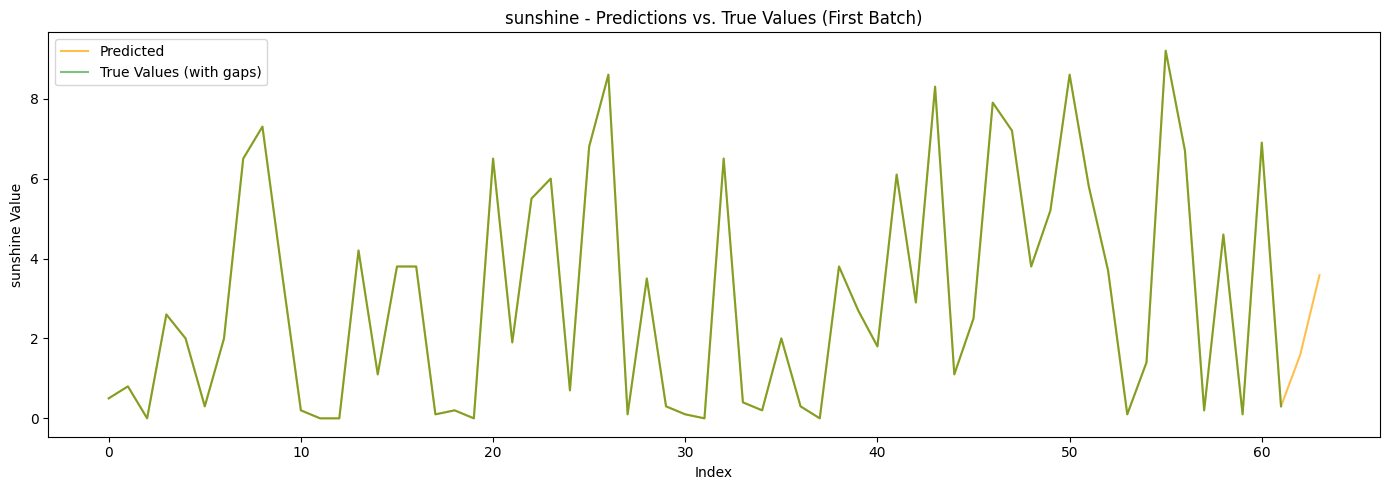

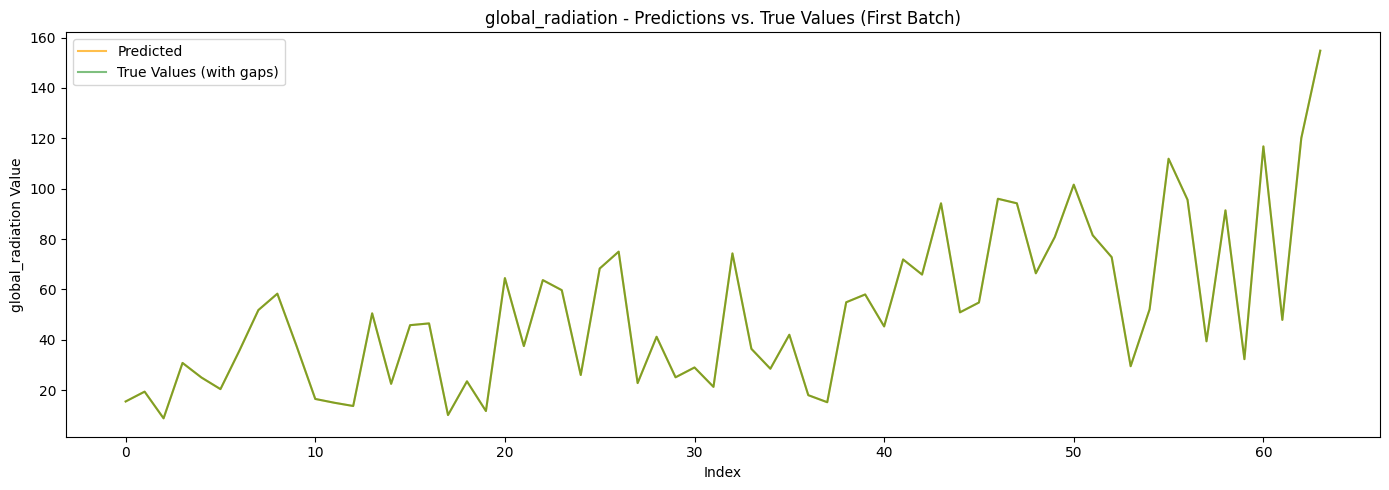

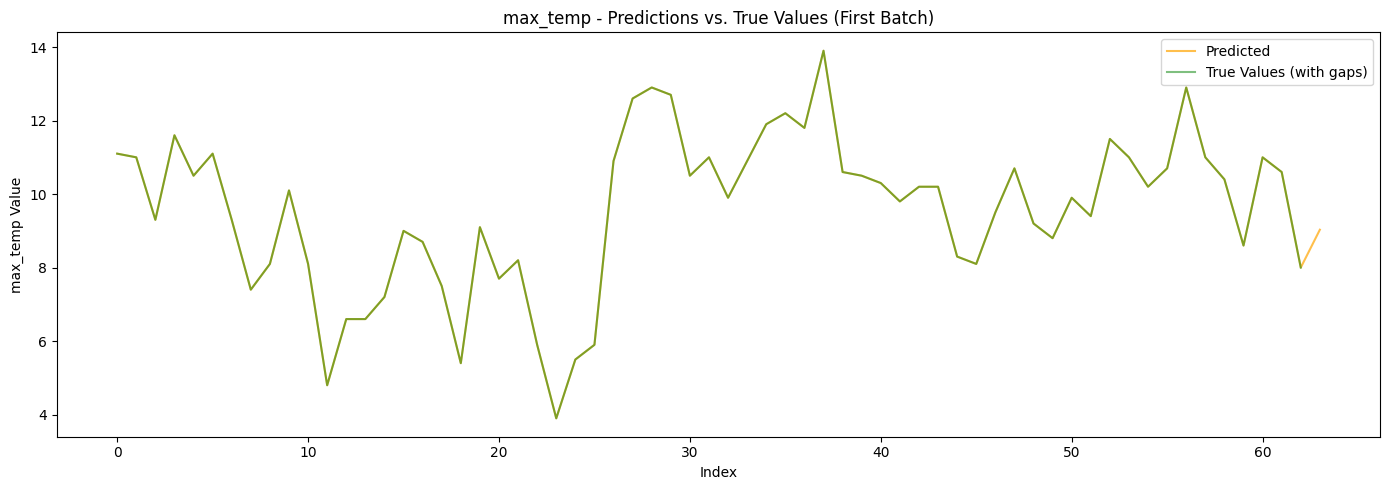

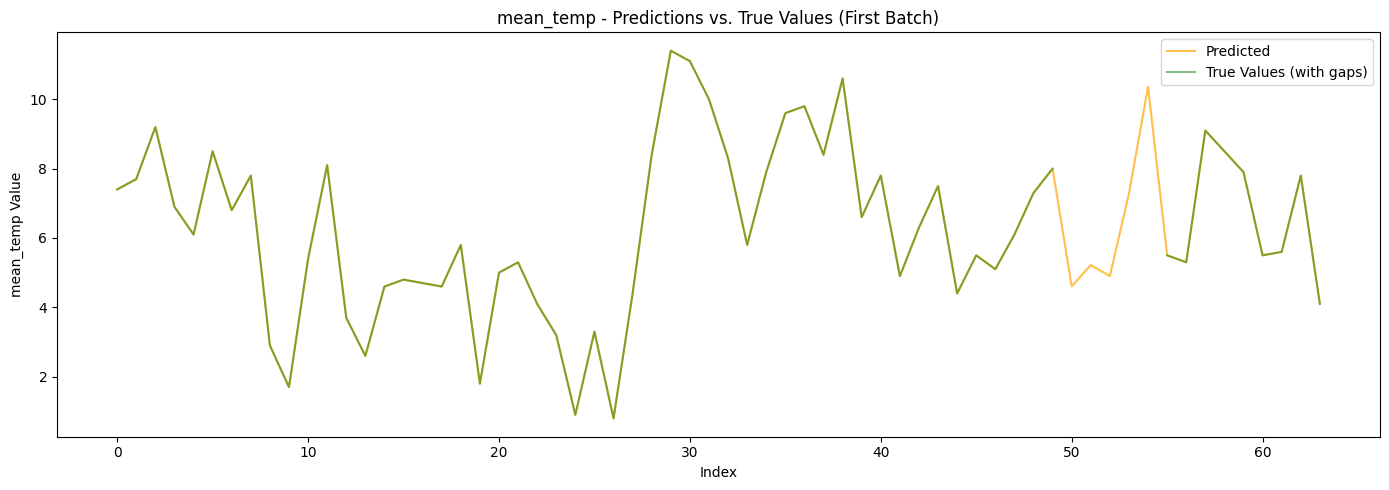

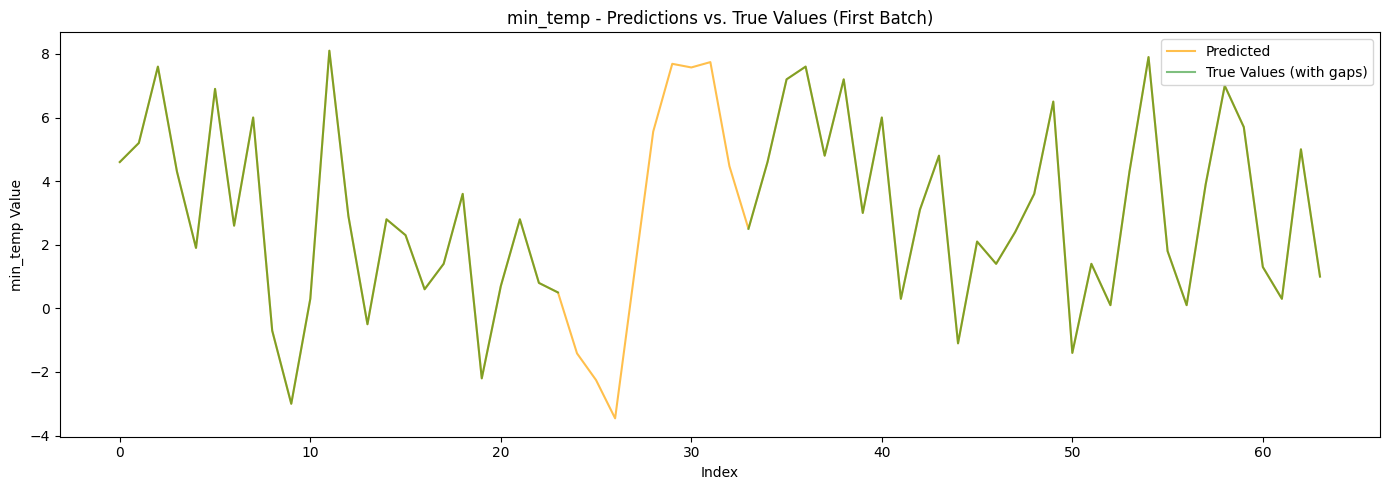

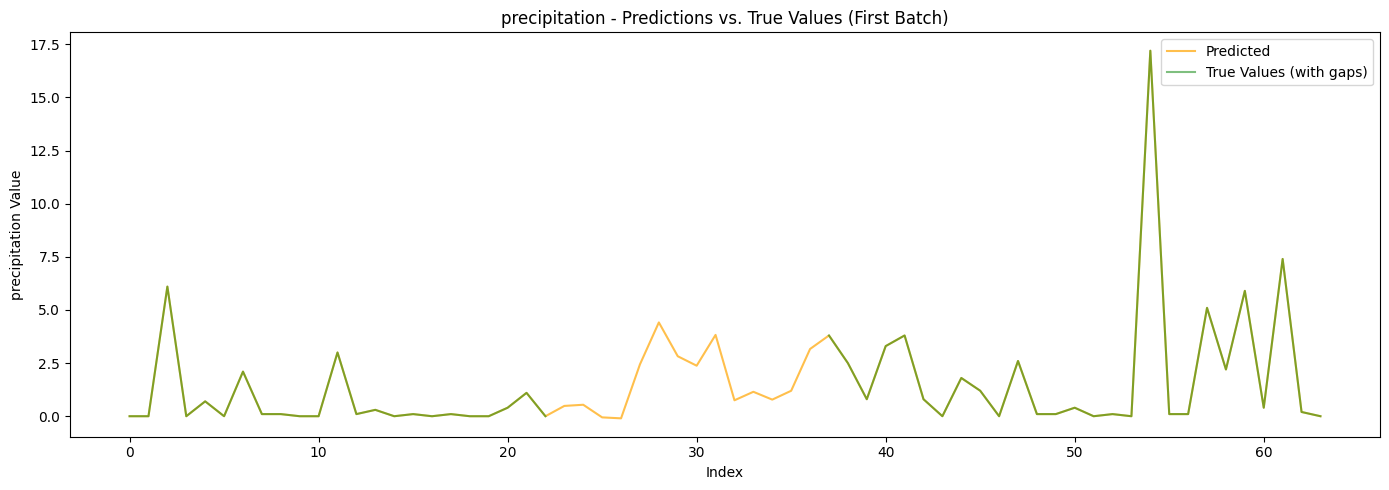

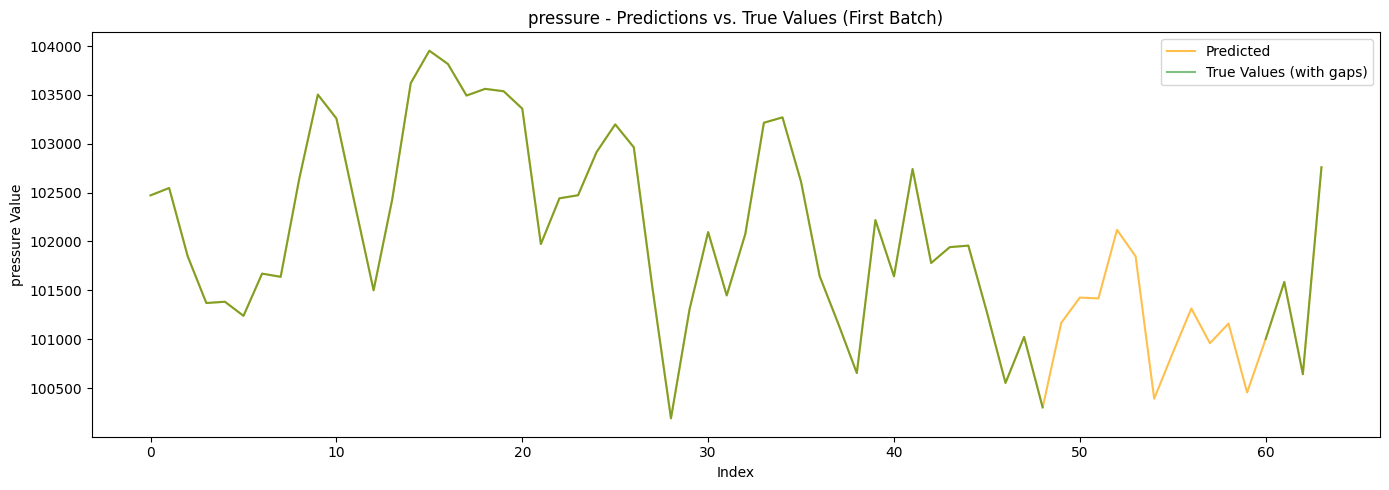

In [52]:
# written withe the help of ChatGPT - Reference 6
# Assuming model, test_loader, and device are defined
model_trained.eval()

# Get the first batch of data from the test_loader (no labels in test)
data, mask = next(iter(test_loader))  # data, mask from test_loader (no labels in test)
data, mask = data.to(device), mask.to(device)

# Make predictions for this batch
output = model_trained(data, mask)

# Collect the predictions
output_list = []
for i in range(data.shape[0]):
    output_list.append(output[i, -1, :].cpu().detach().numpy())

output = np.array(output_list)  # Shape: (batch_size, num_features)

# Reverse normalization (RobustScaler + log1p)
# Reverse the RobustScaler transformation
pred_df = pd.DataFrame(scaler.inverse_transform(output), columns=columns)

# Now, get the corresponding true values (non-missing values from test_set_df)
# Extract the first 64 samples (same as the batch size)
true_values = test_set_df[columns].iloc[:64].reset_index(drop=True)

# Plot the predictions vs true values for this batch
for col in columns:
    plt.figure(figsize=(14, 5))

    # Predicted values (reverse-normalized)
    predicted_values = pred_df[col].values
    true_values_col = true_values[col].values

    # Plot the predicted values (orange) and the true values (green)
    plt.plot(predicted_values, color='orange', label='Predicted', linestyle='-', alpha=0.7)
    plt.plot(true_values_col, color='green', alpha=0.5, label='True Values (with gaps)')

    # Add titles and labels
    plt.title(f'{col} - Predictions vs. True Values (First Batch)')
    plt.xlabel('Index')
    plt.ylabel(f'{col} Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [53]:
model_trained.eval()

all_predictions = []

for data, mask in test_loader:
    data, mask = data.to(device), mask.to(device)

    output = model_trained(data, mask)

    output_list = []
    for i in range(data.shape[0]):
        output_list.append(output[i, -1, :].cpu().detach().numpy())

    all_predictions.append(np.array(output_list))

all_predictions = np.concatenate(all_predictions, axis=0)

pred_df = pd.DataFrame(scaler.inverse_transform(all_predictions), columns=columns)

In [54]:
pred_df

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0        0.0     7.100000       0.5         15.499998      11.1   7.400000   
1        1.0     7.100000       0.8         19.400000      11.0   7.700000   
2        2.0     8.000000       0.0          8.800001       9.3   9.200000   
3        3.0     4.900000       2.6         30.799997      11.6   6.900000   
4        4.0     5.833485       2.0         24.999998      10.5   6.100000   
...      ...          ...       ...               ...       ...        ...   
3647  3647.0     4.100000       1.6         32.200001       7.8   5.072097   
3648  3648.0     2.000000       1.9         24.100004       5.3   4.662135   
3649  3649.0     2.200000       3.8         34.400002       4.8   2.901247   
3650  3650.0     7.900000       0.0          7.499999       5.1   4.874123   
3651  3651.0     8.100000       0.1         17.700003       4.2   6.246153   

      min_temp  precipitation       pressure  
0     4.600000  -1.788139e-08  102472.101562  
1     5.200000  -1.788139e-08  102547.203125  
2     7.600000   6.100000e+00  101847.398438  
3     4.300000  -1.788139e-08  101370.398438  
4     1.900000   7.000000e-01  101383.296875  
...        ...            ...            ...  
3647  2.000000   2.000000e-01  100024.101562  
3648  4.800000  -1.788139e-08   99900.101562  
3649 -2.299999   7.000000e-01  100411.296875  
3650 -1.000000   1.270000e+01   99516.703125  
3651  4.000000   3.600000e+00   99200.796875  

[3652 rows x 9 columns]

In [55]:
test_set_df

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0        0          7.1       0.5              15.5      11.1        7.4   
1        1          7.1       0.8              19.4      11.0        7.7   
2        2          8.0       0.0               8.8       9.3        9.2   
3        3          4.9       2.6              30.8      11.6        6.9   
4        4          NaN       2.0              25.0      10.5        6.1   
...    ...          ...       ...               ...       ...        ...   
3647  3647          4.1       1.6              32.2       7.8        NaN   
3648  3648          2.0       1.9              24.1       5.3        NaN   
3649  3649          2.2       3.8              34.4       4.8        NaN   
3650  3650          7.9       0.0               7.5       5.1        NaN   
3651  3651          8.1       0.1              17.7       4.2        NaN   

      min_temp  precipitation  pressure  
0          4.6            0.0  102472.1  
1          5.2            0.0  102547.2  
2          7.6            6.1  101847.4  
3          4.3            0.0  101370.4  
4          1.9            0.7  101383.3  
...        ...            ...       ...  
3647       2.0            0.2  100024.1  
3648       4.8            0.0   99900.1  
3649      -2.3            0.7  100411.3  
3650      -1.0           12.7   99516.7  
3651       4.0            3.6   99200.8  

[3652 rows x 9 columns]

In [56]:
mask_test = (test_set_df.isna()).astype(float)
mask_test

date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0      0.0          0.0       0.0               0.0       0.0        0.0   
1      0.0          0.0       0.0               0.0       0.0        0.0   
2      0.0          0.0       0.0               0.0       0.0        0.0   
3      0.0          0.0       0.0               0.0       0.0        0.0   
4      0.0          1.0       0.0               0.0       0.0        0.0   
...    ...          ...       ...               ...       ...        ...   
3647   0.0          0.0       0.0               0.0       0.0        1.0   
3648   0.0          0.0       0.0               0.0       0.0        1.0   
3649   0.0          0.0       0.0               0.0       0.0        1.0   
3650   0.0          0.0       0.0               0.0       0.0        1.0   
3651   0.0          0.0       0.0               0.0       0.0        1.0   

      min_temp  precipitation  pressure  
0          0.0            0.0       0.0  
1          0.0            0.0       0.0  
2          0.0            0.0       0.0  
3          0.0            0.0       0.0  
4          0.0            0.0       0.0  
...        ...            ...       ...  
3647       0.0            0.0       0.0  
3648       0.0            0.0       0.0  
3649       0.0            0.0       0.0  
3650       0.0            0.0       0.0  
3651       0.0            0.0       0.0  

[3652 rows x 9 columns]

In [57]:
output_path='/content/drive/MyDrive/Cw_deeplearning_2/test_set_nogaps.csv'

mask_test_arr = np.array(mask_test)
mask_test_arr = mask_test_arr.astype(bool)

final_df = test_set_df.copy()

for row in range(test_set_df.shape[0]):
    for col in range(test_set_df.shape[1]):
        if mask_test_arr[row, col]:
            final_df.iloc[row, col] = pred_df.iloc[row, col]

final_df.to_csv(output_path, index=False)



### Conclusion

Initially, I considered using a Feedforward Neural Network (FFN) for this task, as it only requires numerical values. However, given the time dependencies between the data from each day, I realized that a model designed to handle sequences would be more suitable. That is why I chose a RNN using a LSTM cell instead of a vanilla RNN cell.

Before creating the datasets and dataloaders, I **normalized the values in both my training and test sets to improve training efficiency and convergence**. I tested the model without normalization, but it resulted in a significantly high loss and poor predictions.

To create my dataset, I **generated sequences of length `seq_len` using data spanning several days, as my RNN model requires sequential input**. I concatenated data from all three decades into a single dataframe, which caused some sequences to span across decades. Although the decades are not necessarily consecutive, this was not a significant issue depending on the value of `seq_len`. Either the boundaries between decades aligned perfectly with the sequence slicing, or sequences contained a mix of days from two decades (for example: two days from one decade and three from another). This introduced a minor error at the start or end of each decade. For future improvements, given more time, I would consider exploring a model that does not rely on sequences or creating separate training sets for each decade.

I **chose `seq_len` based on a correlation matrix that showed the relationships between features across several days**. I chose `seq_len = 4` because it was the sequence of days with the highest correlations, providing sufficient feature information for accurate predictions.

After several attempts to train my model, I realized that I needed to **add padding (depending on `seq_len`) to my training and test dataframes before transforming them**. Without this padding, some rows were missing in the predictions of both the training and test datasets. As a result, the number of rows in the `test_loader` did not match the number of rows in `test_set_df` when I tested my model.

To optimize the learning rate and weight decay parameters, I began by training the model for ten epochs to observe the loss curve. Based on these observations, I made adjustments: I increased the values, to reduce the loss. However, I decided to use a validation set to ensure that I wasn't overfitting. Unfortunately, the model did show signs of overfitting to some extent. To address this problem, I increased the dropout parameter in the LSTM layer. After testing various combinations of hyperparameters, I settled on `lr = 1e-4`, `weight_decay = 1e-5`, and `dropout = 0.6`. While overfitting still persists to some degree, I believe it is manageable for now. Given more time, I would have continued training the model to further refine the results.



<br>

---

<br>